In [62]:
base = 'subtitles_fragments'
extractors_types=['alchemy', 'adel', 'opencalais','dandelion', 'dbspotlight', 'babelfy', 'textrazor','meaning_cloud']

In [48]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['score', 'uris', 'fasttext']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best_type/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True,                                         W_regularizer=l2(reg_alpha),                                         U_regularizer=l2(reg_alpha),                                         b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj_type = dict()
model_obj_type['train_X'] = X_dict_train
model_obj_type['train_Y'] = {'main_output': train_Y}
model_obj_type['test_X'] = X_dict_test
model_obj_type['test_Y'] = {'main_output': test_Y}
model_obj_type['path'] = saving_folder+'model.h5'
model_obj_type['inv_types_map'] = inv_types_map
model_obj_type['types_dict'] = types_dict
model_obj_type['max_fragment_len'] = max_fragment_len
model_obj_type['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
concatenation = concatenate(to_concatenate_layers_out)

main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj_type
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj_type['max_fragment_len']
        self.inv_types_map = model_obj_type['inv_types_map']
        self.history_scores = list()
        self.types = model_obj_type['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj_type
        x, y = model_obj_type['test_X'],model_obj_type['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj_type['test_X'],model_obj_type['test_Y'])[0]
        loss = model.evaluate(model_obj_type['train_X'],model_obj_type['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj_type['path'])


    def on_train_end(self,logs={}):
        global model_obj_type
        model_obj_type['history_scores'] = self.history_scores
        md = load_model(model_obj_type['path'])
        predicted_test = md.predict(model_obj_type['test_X'],verbose=0)
        predicted_train= md.predict(model_obj_type['train_X'],verbose=0)
        model_obj_type['predicted_train'],model_obj_type['predicted_test'] = predicted_train,predicted_test

        model_obj_type['extractors_mapping'] = dict()

        pickle.dump( model_obj_type, open( self.saving_folder+'model_obj_type.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj_type['train_X'], model_obj_type['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj_type, gt_test,saving_folder),early_stop],validation_data = (model_obj_type['test_X'], model_obj_type['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)

Parsed
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
scorealchemy (InputLayer)        (None, 1)             0                                            
____________________________________________________________________________________________________
scoreadel (InputLayer)           (None, 1)             0                                            
____________________________________________________________________________________________________
scoreopencalais (InputLayer)     (None, 1)             0                                            
____________________________________________________________________________________________________
scoredandelion (InputLayer)      (None, 1)             0                                            
____________________________________________________________________________________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


15680/15680 [==============================] - 9s - loss: 0.0780 - mean_absolute_error: 0.2173 - acc: 0.1621 - val_loss: 0.0274 - val_mean_absolute_error: 0.0901 - val_acc: 0.1373
Epoch 2/1000
15296/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.391691394659
F1 on type Person: 0.599033816425
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.361581920904
Global F1 ( macro ) : 0.247681302771
Global F1 ( weighted ) : 0.331844218533
15680/15680 [==============================] - 5s - loss: 0.0227 - mean_absolute_error: 0.0734 - acc: 0.6296 - val_loss: 0.0217 - val_mean_absolute_error: 0.0624 - val_acc: 0.1357
Epoch 3/1000
15552/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.5768321513
F1 on type Person: 0.827309236948
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.538277511962
Global F1 ( macro ) : 0.351035347062
Global F1 ( weighted ) : 0.474763332746
15680/15680 [==============================] -

15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.674259681093
F1 on type Person: 0.893617021277
F1 on type Place: 0.624
F1 on type Role: 0.741176470588
Global F1 ( micro ) : 0.740157480315
Global F1 ( macro ) : 0.73326329324
Global F1 ( weighted ) : 0.73604930226
15680/15680 [==============================] - 4s - loss: 0.0079 - mean_absolute_error: 0.0220 - acc: 0.1943 - val_loss: 0.0128 - val_mean_absolute_error: 0.0288 - val_acc: 0.2059
Epoch 19/1000
15328/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.657596371882
F1 on type Person: 0.897526501767
F1 on type Place: 0.625
F1 on type Role: 0.741176470588
Global F1 ( micro ) : 0.735586481113
Global F1 ( macro ) : 0.730324836059
Global F1 ( weighted ) : 0.729508299909
15680/15680 [==============================] - 4s - loss: 0.0078 - mean_absolute_error: 0.0213 - acc: 0.2024 - val_loss: 0.0128 - val_mean_absolute_error: 0.0278 - val_acc: 0.2043
Epoch 20/1000
15360/15680 [=====

15168/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.655021834061
F1 on type Person: 0.910344827586
F1 on type Place: 0.56880733945
F1 on type Role: 0.709302325581
Global F1 ( micro ) : 0.726919339164
Global F1 ( macro ) : 0.71086908167
Global F1 ( weighted ) : 0.719701616124
15680/15680 [==============================] - 4s - loss: 0.0066 - mean_absolute_error: 0.0150 - acc: 0.2644 - val_loss: 0.0130 - val_mean_absolute_error: 0.0225 - val_acc: 0.2366
Epoch 35/1000
15680/15680 [==============================] - 1s     
F1 on type Organization: 0.665226781857
F1 on type Person: 0.914675767918
F1 on type Place: 0.576576576577
F1 on type Role: 0.701754385965
Global F1 ( micro ) : 0.732177263969
Global F1 ( macro ) : 0.714558378079
Global F1 ( weighted ) : 0.72503282433
15680/15680 [==============================] - 4s - loss: 0.0065 - mean_absolute_error: 0.0148 - acc: 0.2462 - val_loss: 0.0130 - val_mean_absolute_error: 0.0225 - val_acc: 0.2375
Epoch 36/1000


15680/15680 [==============================] - 4s - loss: 0.0060 - mean_absolute_error: 0.0122 - acc: 0.2131 - val_loss: 0.0136 - val_mean_absolute_error: 0.0209 - val_acc: 0.2573
Epoch 51/1000
15200/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.662473794549
F1 on type Person: 0.900343642612
F1 on type Place: 0.550458715596
F1 on type Role: 0.70652173913
Global F1 ( micro ) : 0.723845428841
Global F1 ( macro ) : 0.704949472972
Global F1 ( weighted ) : 0.71803764284
15680/15680 [==============================] - 4s - loss: 0.0060 - mean_absolute_error: 0.0121 - acc: 0.2728 - val_loss: 0.0139 - val_mean_absolute_error: 0.0216 - val_acc: 0.2393
Epoch 52/1000
15328/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.662447257384
F1 on type Person: 0.907849829352
F1 on type Place: 0.550458715596
F1 on type Role: 0.723163841808
Global F1 ( micro ) : 0.729344729345
Global F1 ( macro ) : 0.710979911035
Global F1 ( weighted ) : 0.72284614478
1

15680/15680 [==============================] - 4s - loss: 0.0056 - mean_absolute_error: 0.0107 - acc: 0.2217 - val_loss: 0.0143 - val_mean_absolute_error: 0.0206 - val_acc: 0.2470
Epoch 67/1000
15680/15680 [==============================] - 1s     
F1 on type Organization: 0.673511293634
F1 on type Person: 0.903448275862
F1 on type Place: 0.571428571429
F1 on type Role: 0.696629213483
Global F1 ( micro ) : 0.729147141518
Global F1 ( macro ) : 0.711254338602
Global F1 ( weighted ) : 0.724508421807
15680/15680 [==============================] - 4s - loss: 0.0056 - mean_absolute_error: 0.0107 - acc: 0.2216 - val_loss: 0.0143 - val_mean_absolute_error: 0.0203 - val_acc: 0.2245
Epoch 68/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.669387755102
F1 on type Person: 0.907216494845
F1 on type Place: 0.542056074766
F1 on type Role: 0.689655172414
Global F1 ( micro ) : 0.725047080979
Global F1 ( macro ) : 0.702078874282
Global F1 ( weighted ) : 0.7190597016

15520/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.678936605317
F1 on type Person: 0.910344827586
F1 on type Place: 0.563636363636
F1 on type Role: 0.666666666667
Global F1 ( micro ) : 0.727954971857
Global F1 ( macro ) : 0.704896115802
Global F1 ( weighted ) : 0.72262834419
15680/15680 [==============================] - 4s - loss: 0.0054 - mean_absolute_error: 0.0097 - acc: 0.2143 - val_loss: 0.0146 - val_mean_absolute_error: 0.0197 - val_acc: 0.2227
Epoch 84/1000
15232/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.678861788618
F1 on type Person: 0.913494809689
F1 on type Place: 0.542056074766
F1 on type Role: 0.688524590164
Global F1 ( micro ) : 0.730158730159
Global F1 ( macro ) : 0.705734315809
Global F1 ( weighted ) : 0.724803124035
15680/15680 [==============================] - 4s - loss: 0.0054 - mean_absolute_error: 0.0095 - acc: 0.2165 - val_loss: 0.0146 - val_mean_absolute_error: 0.0197 - val_acc: 0.2173
Epoch 85/1000

15200/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.670781893004
F1 on type Person: 0.910344827586
F1 on type Place: 0.58407079646
F1 on type Role: 0.685082872928
Global F1 ( micro ) : 0.728971962617
Global F1 ( macro ) : 0.712570097495
Global F1 ( weighted ) : 0.724402231582
15680/15680 [==============================] - 4s - loss: 0.0052 - mean_absolute_error: 0.0090 - acc: 0.2158 - val_loss: 0.0149 - val_mean_absolute_error: 0.0194 - val_acc: 0.2148
Epoch 100/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.677754677755
F1 on type Person: 0.912891986063
F1 on type Place: 0.552380952381
F1 on type Role: 0.666666666667
Global F1 ( micro ) : 0.727445394112
Global F1 ( macro ) : 0.702423570716
Global F1 ( weighted ) : 0.721471298021
15680/15680 [==============================] - 4s - loss: 0.0052 - mean_absolute_error: 0.0089 - acc: 0.2081 - val_loss: 0.0147 - val_mean_absolute_error: 0.0191 - val_acc: 0.2368
Epoch 101/10

15680/15680 [==============================] - 4s - loss: 0.0051 - mean_absolute_error: 0.0085 - acc: 0.2112 - val_loss: 0.0149 - val_mean_absolute_error: 0.0188 - val_acc: 0.2111
Epoch 116/1000
15328/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.676229508197
F1 on type Person: 0.909722222222
F1 on type Place: 0.555555555556
F1 on type Role: 0.666666666667
Global F1 ( micro ) : 0.725563909774
Global F1 ( macro ) : 0.70204348816
Global F1 ( weighted ) : 0.720322374067
15680/15680 [==============================] - 4s - loss: 0.0050 - mean_absolute_error: 0.0084 - acc: 0.2022 - val_loss: 0.0150 - val_mean_absolute_error: 0.0190 - val_acc: 0.2325
Epoch 117/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.665254237288
F1 on type Person: 0.91095890411
F1 on type Place: 0.581818181818
F1 on type Role: 0.666666666667
Global F1 ( micro ) : 0.724857685009
Global F1 ( macro ) : 0.706174497471
Global F1 ( weighted ) : 0.71854410082

In [49]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['type']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best_type_b/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True,                                         W_regularizer=l2(reg_alpha),                                         U_regularizer=l2(reg_alpha),                                         b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj_type = dict()
model_obj_type['train_X'] = X_dict_train
model_obj_type['train_Y'] = {'main_output': train_Y}
model_obj_type['test_X'] = X_dict_test
model_obj_type['test_Y'] = {'main_output': test_Y}
model_obj_type['path'] = saving_folder+'model.h5'
model_obj_type['inv_types_map'] = inv_types_map
model_obj_type['types_dict'] = types_dict
model_obj_type['max_fragment_len'] = max_fragment_len
model_obj_type['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
concatenation = concatenate(to_concatenate_layers_out)

main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj_type
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj_type['max_fragment_len']
        self.inv_types_map = model_obj_type['inv_types_map']
        self.history_scores = list()
        self.types = model_obj_type['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj_type
        x, y = model_obj_type['test_X'],model_obj_type['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj_type['test_X'],model_obj_type['test_Y'])[0]
        loss = model.evaluate(model_obj_type['train_X'],model_obj_type['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj_type['path'])


    def on_train_end(self,logs={}):
        global model_obj_type
        model_obj_type['history_scores'] = self.history_scores
        md = load_model(model_obj_type['path'])
        predicted_test = md.predict(model_obj_type['test_X'],verbose=0)
        predicted_train= md.predict(model_obj_type['train_X'],verbose=0)
        model_obj_type['predicted_train'],model_obj_type['predicted_test'] = predicted_train,predicted_test

        model_obj_type['extractors_mapping'] = dict()

        pickle.dump( model_obj_type, open( self.saving_folder+'model_obj_type.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj_type['train_X'], model_obj_type['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj_type, gt_test,saving_folder),early_stop],validation_data = (model_obj_type['test_X'], model_obj_type['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)

Parsed
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
typealchemy (InputLayer)         (None, 465)           0                                            
____________________________________________________________________________________________________
typeadel (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
typeopencalais (InputLayer)      (None, 43)            0                                            
____________________________________________________________________________________________________
typedandelion (InputLayer)       (None, 15)            0                                            
____________________________________________________________________________________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


15680/15680 [==============================] - 7s - loss: 0.0941 - mean_absolute_error: 0.2583 - acc: 0.6386 - val_loss: 0.0260 - val_mean_absolute_error: 0.1100 - val_acc: 0.9166
Epoch 2/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.738095238095
F1 on type Person: 0.710526315789
F1 on type Place: 0.792452830189
F1 on type Role: 0.0
Global F1 ( micro ) : 0.651053864169
Global F1 ( macro ) : 0.560268596018
Global F1 ( weighted ) : 0.607923378813
15680/15680 [==============================] - 4s - loss: 0.0178 - mean_absolute_error: 0.0804 - acc: 0.8561 - val_loss: 0.0162 - val_mean_absolute_error: 0.0636 - val_acc: 0.9373
Epoch 3/1000
15264/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.8125
F1 on type Person: 0.731914893617
F1 on type Place: 0.877192982456
F1 on type Role: 0.019801980198
Global F1 ( micro ) : 0.710467706013
Global F1 ( macro ) : 0.610352464068
Global F1 ( weighted ) : 0.660460960545
15680/15680 [======

15680/15680 [==============================] - 4s - loss: 0.0041 - mean_absolute_error: 0.0156 - acc: 0.1399 - val_loss: 0.0050 - val_mean_absolute_error: 0.0165 - val_acc: 0.1502
Epoch 18/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.911290322581
F1 on type Person: 0.903914590747
F1 on type Place: 0.899224806202
F1 on type Role: 0.901554404145
Global F1 ( micro ) : 0.906278434941
Global F1 ( macro ) : 0.903996030919
Global F1 ( weighted ) : 0.906359909257
15680/15680 [==============================] - 4s - loss: 0.0040 - mean_absolute_error: 0.0149 - acc: 0.1408 - val_loss: 0.0050 - val_mean_absolute_error: 0.0161 - val_acc: 0.1457
Epoch 19/1000
15040/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.911290322581
F1 on type Person: 0.907142857143
F1 on type Place: 0.899224806202
F1 on type Role: 0.91
Global F1 ( micro ) : 0.908597285068
Global F1 ( macro ) : 0.906914496481
Global F1 ( weighted ) : 0.908658785287
15680/15

15200/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.907630522088
F1 on type Person: 0.903914590747
F1 on type Place: 0.911764705882
F1 on type Role: 0.887755102041
Global F1 ( micro ) : 0.903690369037
Global F1 ( macro ) : 0.90276623019
Global F1 ( weighted ) : 0.903669463793
15680/15680 [==============================] - 4s - loss: 0.0034 - mean_absolute_error: 0.0096 - acc: 0.1368 - val_loss: 0.0050 - val_mean_absolute_error: 0.0118 - val_acc: 0.1402
Epoch 35/1000
15520/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.907630522088
F1 on type Person: 0.910394265233
F1 on type Place: 0.903703703704
F1 on type Role: 0.916256157635
Global F1 ( micro ) : 0.909417040359
Global F1 ( macro ) : 0.909496162165
Global F1 ( weighted ) : 0.909402833707
15680/15680 [==============================] - 4s - loss: 0.0034 - mean_absolute_error: 0.0097 - acc: 0.1348 - val_loss: 0.0050 - val_mean_absolute_error: 0.0112 - val_acc: 0.1425
Epoch 36/1000

15392/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905432595573
F1 on type Person: 0.9
F1 on type Place: 0.903703703704
F1 on type Role: 0.877551020408
Global F1 ( micro ) : 0.898916967509
Global F1 ( macro ) : 0.896671829921
Global F1 ( weighted ) : 0.898976320697
15680/15680 [==============================] - 4s - loss: 0.0031 - mean_absolute_error: 0.0075 - acc: 0.1360 - val_loss: 0.0052 - val_mean_absolute_error: 0.0101 - val_acc: 0.1398
Epoch 51/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905432595573
F1 on type Person: 0.903225806452
F1 on type Place: 0.903703703704
F1 on type Role: 0.878787878788
Global F1 ( micro ) : 0.899909828674
Global F1 ( macro ) : 0.897787496129
Global F1 ( weighted ) : 0.900012096132
15680/15680 [==============================] - 4s - loss: 0.0031 - mean_absolute_error: 0.0075 - acc: 0.1374 - val_loss: 0.0052 - val_mean_absolute_error: 0.0100 - val_acc: 0.1386
Epoch 52/1000
15680/156

15680/15680 [==============================] - 4s - loss: 0.0029 - mean_absolute_error: 0.0064 - acc: 0.1372 - val_loss: 0.0053 - val_mean_absolute_error: 0.0092 - val_acc: 0.1373
Epoch 66/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905811623246
F1 on type Person: 0.895306859206
F1 on type Place: 0.903703703704
F1 on type Role: 0.891089108911
Global F1 ( micro ) : 0.900269541779
Global F1 ( macro ) : 0.898977823767
Global F1 ( weighted ) : 0.900329400707
15680/15680 [==============================] - 4s - loss: 0.0030 - mean_absolute_error: 0.0064 - acc: 0.1352 - val_loss: 0.0053 - val_mean_absolute_error: 0.0091 - val_acc: 0.1400
Epoch 67/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.903614457831
F1 on type Person: 0.895306859206
F1 on type Place: 0.903703703704
F1 on type Role: 0.883248730964
Global F1 ( micro ) : 0.897922312556
Global F1 ( macro ) : 0.896468437926
Global F1 ( weighted ) : 0.89794814828

15680/15680 [==============================] - 4s - loss: 0.0028 - mean_absolute_error: 0.0056 - acc: 0.1384 - val_loss: 0.0055 - val_mean_absolute_error: 0.0088 - val_acc: 0.1382
Epoch 82/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905432595573
F1 on type Person: 0.887272727273
F1 on type Place: 0.903703703704
F1 on type Role: 0.888888888889
Global F1 ( micro ) : 0.897737556561
Global F1 ( macro ) : 0.89632447886
Global F1 ( weighted ) : 0.897729967462
15680/15680 [==============================] - 4s - loss: 0.0028 - mean_absolute_error: 0.0056 - acc: 0.1364 - val_loss: 0.0055 - val_mean_absolute_error: 0.0086 - val_acc: 0.1386
Epoch 83/1000
15104/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.903614457831
F1 on type Person: 0.884057971014
F1 on type Place: 0.903703703704
F1 on type Role: 0.887755102041
Global F1 ( micro ) : 0.89592760181
Global F1 ( macro ) : 0.894782808648
Global F1 ( weighted ) : 0.895880807338


15680/15680 [==============================] - 4s - loss: 0.0028 - mean_absolute_error: 0.0050 - acc: 0.1425 - val_loss: 0.0057 - val_mean_absolute_error: 0.0083 - val_acc: 0.1366
Epoch 98/1000
15456/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.907630522088
F1 on type Person: 0.887272727273
F1 on type Place: 0.903703703704
F1 on type Role: 0.882051282051
Global F1 ( micro ) : 0.897552130553
Global F1 ( macro ) : 0.895164558779
Global F1 ( weighted ) : 0.897540993842
15680/15680 [==============================] - 4s - loss: 0.0028 - mean_absolute_error: 0.0050 - acc: 0.1357 - val_loss: 0.0055 - val_mean_absolute_error: 0.0081 - val_acc: 0.1423
Epoch 99/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.907630522088
F1 on type Person: 0.884057971014
F1 on type Place: 0.903703703704
F1 on type Role: 0.878306878307
Global F1 ( micro ) : 0.896174863388
Global F1 ( macro ) : 0.893424768778
Global F1 ( weighted ) : 0.89606887469

15680/15680 [==============================] - 4s - loss: 0.0027 - mean_absolute_error: 0.0046 - acc: 0.1411 - val_loss: 0.0057 - val_mean_absolute_error: 0.0080 - val_acc: 0.1373
Epoch 114/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.906504065041
F1 on type Person: 0.884057971014
F1 on type Place: 0.903703703704
F1 on type Role: 0.884210526316
Global F1 ( micro ) : 0.896614821592
Global F1 ( macro ) : 0.894619066519
Global F1 ( weighted ) : 0.896585920326
15680/15680 [==============================] - 4s - loss: 0.0027 - mean_absolute_error: 0.0046 - acc: 0.1429 - val_loss: 0.0057 - val_mean_absolute_error: 0.0080 - val_acc: 0.1370
Epoch 115/1000
15104/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.906504065041
F1 on type Person: 0.884057971014
F1 on type Place: 0.903703703704
F1 on type Role: 0.884210526316
Global F1 ( micro ) : 0.896614821592
Global F1 ( macro ) : 0.894619066519
Global F1 ( weighted ) : 0.896585920

In [50]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['type', 'uris', 'fasttext']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best_score/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True,                                         W_regularizer=l2(reg_alpha),                                         U_regularizer=l2(reg_alpha),                                         b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj_score = dict()
model_obj_score['train_X'] = X_dict_train
model_obj_score['train_Y'] = {'main_output': train_Y}
model_obj_score['test_X'] = X_dict_test
model_obj_score['test_Y'] = {'main_output': test_Y}
model_obj_score['path'] = saving_folder+'model.h5'
model_obj_score['inv_types_map'] = inv_types_map
model_obj_score['types_dict'] = types_dict
model_obj_score['max_fragment_len'] = max_fragment_len
model_obj_score['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
concatenation = concatenate(to_concatenate_layers_out)

main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj_score
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj_score['max_fragment_len']
        self.inv_types_map = model_obj_score['inv_types_map']
        self.history_scores = list()
        self.types = model_obj_score['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj_score
        x, y = model_obj_score['test_X'],model_obj_score['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj_score['test_X'],model_obj_score['test_Y'])[0]
        loss = model.evaluate(model_obj_score['train_X'],model_obj_score['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj_score['path'])


    def on_train_end(self,logs={}):
        global model_obj_score
        model_obj_score['history_scores'] = self.history_scores
        md = load_model(model_obj_score['path'])
        predicted_test = md.predict(model_obj_score['test_X'],verbose=0)
        predicted_train= md.predict(model_obj_score['train_X'],verbose=0)
        model_obj_score['predicted_train'],model_obj_score['predicted_test'] = predicted_train,predicted_test

        model_obj_score['extractors_mapping'] = dict()
        
        pickle.dump(model_obj_score, open( self.saving_folder+'model_obj_score.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj_score['train_X'], model_obj_score['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj_score, gt_test,saving_folder),early_stop],validation_data = (model_obj_score['test_X'], model_obj_score['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)

Parsed
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
typealchemy (InputLayer)         (None, 465)           0                                            
____________________________________________________________________________________________________
typeadel (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
typeopencalais (InputLayer)      (None, 43)            0                                            
____________________________________________________________________________________________________
typedandelion (InputLayer)       (None, 15)            0                                            
____________________________________________________________________________________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


15680/15680 [==============================] - 9s - loss: 0.0718 - mean_absolute_error: 0.2116 - acc: 0.1255 - val_loss: 0.0200 - val_mean_absolute_error: 0.0807 - val_acc: 0.1523
Epoch 2/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.801801801802
F1 on type Person: 0.773109243697
F1 on type Place: 0.857142857143
F1 on type Role: 0.0
Global F1 ( micro ) : 0.711409395973
Global F1 ( macro ) : 0.608013475661
Global F1 ( weighted ) : 0.660297820079
15680/15680 [==============================] - 5s - loss: 0.0141 - mean_absolute_error: 0.0630 - acc: 0.1460 - val_loss: 0.0135 - val_mean_absolute_error: 0.0509 - val_acc: 0.1684
Epoch 3/1000
15552/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.84188034188
F1 on type Person: 0.919117647059
F1 on type Place: 0.849557522124
F1 on type Role: 0.258620689655
Global F1 ( micro ) : 0.794633642931
Global F1 ( macro ) : 0.71729405018
Global F1 ( weighted ) : 0.760207458455
15680/15680 [

15680/15680 [==============================] - 5s - loss: 0.0021 - mean_absolute_error: 0.0099 - acc: 0.7996 - val_loss: 0.0041 - val_mean_absolute_error: 0.0135 - val_acc: 0.7773
Epoch 18/1000
15616/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.908023483366
F1 on type Person: 0.964539007092
F1 on type Place: 0.896
F1 on type Role: 0.926315789474
Global F1 ( micro ) : 0.924187725632
Global F1 ( macro ) : 0.923719569983
Global F1 ( weighted ) : 0.924230976563
15680/15680 [==============================] - 5s - loss: 0.0021 - mean_absolute_error: 0.0094 - acc: 0.8045 - val_loss: 0.0041 - val_mean_absolute_error: 0.0126 - val_acc: 0.7516
Epoch 19/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905511811024
F1 on type Person: 0.964788732394
F1 on type Place: 0.896
F1 on type Role: 0.926315789474
Global F1 ( micro ) : 0.923215898826
Global F1 ( macro ) : 0.923154083223
Global F1 ( weighted ) : 0.923141925802
15680/15680 [===

15296/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.908382066277
F1 on type Person: 0.931899641577
F1 on type Place: 0.88188976378
F1 on type Role: 0.91
Global F1 ( micro ) : 0.911528150134
Global F1 ( macro ) : 0.908042867908
Global F1 ( weighted ) : 0.911668116068
15680/15680 [==============================] - 5s - loss: 0.0014 - mean_absolute_error: 0.0050 - acc: 0.8121 - val_loss: 0.0044 - val_mean_absolute_error: 0.0095 - val_acc: 0.7595
Epoch 34/1000
15616/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.904109589041
F1 on type Person: 0.935251798561
F1 on type Place: 0.88188976378
F1 on type Role: 0.893401015228
Global F1 ( micro ) : 0.907457322552
Global F1 ( macro ) : 0.903663041653
Global F1 ( weighted ) : 0.907651960639
15680/15680 [==============================] - 5s - loss: 0.0014 - mean_absolute_error: 0.0048 - acc: 0.8101 - val_loss: 0.0046 - val_mean_absolute_error: 0.0094 - val_acc: 0.7655
Epoch 35/1000
15296/1568

15680/15680 [==============================] - 5s - loss: 0.0011 - mean_absolute_error: 0.0032 - acc: 0.8378 - val_loss: 0.0048 - val_mean_absolute_error: 0.0081 - val_acc: 0.8052
Epoch 50/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.903100775194
F1 on type Person: 0.935251798561
F1 on type Place: 0.88188976378
F1 on type Role: 0.89552238806
Global F1 ( micro ) : 0.907308377897
Global F1 ( macro ) : 0.903941181399
Global F1 ( weighted ) : 0.907560591208
15680/15680 [==============================] - 5s - loss: 0.0011 - mean_absolute_error: 0.0031 - acc: 0.8353 - val_loss: 0.0047 - val_mean_absolute_error: 0.0081 - val_acc: 0.7943
Epoch 51/1000
15456/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905511811024
F1 on type Person: 0.935251798561
F1 on type Place: 0.88188976378
F1 on type Role: 0.90099009901
Global F1 ( micro ) : 0.909417040359
Global F1 ( macro ) : 0.905910868094
Global F1 ( weighted ) : 0.909624448446
15

15680/15680 [==============================] - 5s - loss: 0.0011 - mean_absolute_error: 0.0025 - acc: 0.8416 - val_loss: 0.0048 - val_mean_absolute_error: 0.0073 - val_acc: 0.8027
Epoch 66/1000
15456/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.898832684825
F1 on type Person: 0.942857142857
F1 on type Place: 0.885496183206
F1 on type Role: 0.914572864322
Global F1 ( micro ) : 0.91103202847
Global F1 ( macro ) : 0.910439718802
Global F1 ( weighted ) : 0.911274065317
15680/15680 [==============================] - 5s - loss: 0.0011 - mean_absolute_error: 0.0024 - acc: 0.8402 - val_loss: 0.0047 - val_mean_absolute_error: 0.0073 - val_acc: 0.7966
Epoch 67/1000
15232/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.900584795322
F1 on type Person: 0.942857142857
F1 on type Place: 0.875
F1 on type Role: 0.904522613065
Global F1 ( micro ) : 0.908928571429
Global F1 ( macro ) : 0.905741137811
Global F1 ( weighted ) : 0.909141442023
15680/15

15680/15680 [==============================] - 1s     
F1 on type Organization: 0.90234375
F1 on type Person: 0.94623655914
F1 on type Place: 0.868217054264
F1 on type Role: 0.920792079208
Global F1 ( micro ) : 0.91265597148
Global F1 ( macro ) : 0.909397360653
Global F1 ( weighted ) : 0.912895731995
15680/15680 [==============================] - 4s - loss: 9.9454e-04 - mean_absolute_error: 0.0021 - acc: 0.8381 - val_loss: 0.0048 - val_mean_absolute_error: 0.0071 - val_acc: 0.7893
Epoch 83/1000
15680/15680 [==============================] - 1s     
F1 on type Organization: 0.904483430799
F1 on type Person: 0.942446043165
F1 on type Place: 0.883720930233
F1 on type Role: 0.925373134328
Global F1 ( micro ) : 0.915254237288
Global F1 ( macro ) : 0.914005884631
Global F1 ( weighted ) : 0.915454970396
15680/15680 [==============================] - 5s - loss: 9.9110e-04 - mean_absolute_error: 0.0020 - acc: 0.8381 - val_loss: 0.0048 - val_mean_absolute_error: 0.0071 - val_acc: 0.7977
Epoch 84

15680/15680 [==============================] - 5s - loss: 9.6684e-04 - mean_absolute_error: 0.0019 - acc: 0.8352 - val_loss: 0.0048 - val_mean_absolute_error: 0.0067 - val_acc: 0.7820
Epoch 98/1000
15296/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.904483430799
F1 on type Person: 0.946619217082
F1 on type Place: 0.892307692308
F1 on type Role: 0.935323383085
Global F1 ( micro ) : 0.919111111111
Global F1 ( macro ) : 0.919683430818
Global F1 ( weighted ) : 0.919219747745
15680/15680 [==============================] - 5s - loss: 9.6824e-04 - mean_absolute_error: 0.0018 - acc: 0.8311 - val_loss: 0.0047 - val_mean_absolute_error: 0.0068 - val_acc: 0.7939
Epoch 99/1000
15232/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905138339921
F1 on type Person: 0.95
F1 on type Place: 0.892307692308
F1 on type Role: 0.935323383085
Global F1 ( micro ) : 0.920322291853
Global F1 ( macro ) : 0.920692353828
Global F1 ( weighted ) : 0.920378766507


15680/15680 [==============================] - 4s - loss: 9.4382e-04 - mean_absolute_error: 0.0017 - acc: 0.8269 - val_loss: 0.0048 - val_mean_absolute_error: 0.0065 - val_acc: 0.7718
Epoch 114/1000
15616/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905882352941
F1 on type Person: 0.946619217082
F1 on type Place: 0.892307692308
F1 on type Role: 0.935323383085
Global F1 ( micro ) : 0.919786096257
Global F1 ( macro ) : 0.920033161354
Global F1 ( weighted ) : 0.919861634963
15680/15680 [==============================] - 5s - loss: 9.5227e-04 - mean_absolute_error: 0.0017 - acc: 0.8263 - val_loss: 0.0048 - val_mean_absolute_error: 0.0065 - val_acc: 0.7836


In [51]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['score']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best_score_b/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True,                                         W_regularizer=l2(reg_alpha),                                         U_regularizer=l2(reg_alpha),                                         b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj_score = dict()
model_obj_score['train_X'] = X_dict_train
model_obj_score['train_Y'] = {'main_output': train_Y}
model_obj_score['test_X'] = X_dict_test
model_obj_score['test_Y'] = {'main_output': test_Y}
model_obj_score['path'] = saving_folder+'model.h5'
model_obj_score['inv_types_map'] = inv_types_map
model_obj_score['types_dict'] = types_dict
model_obj_score['max_fragment_len'] = max_fragment_len
model_obj_score['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
concatenation = concatenate(to_concatenate_layers_out)

main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj_score
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj_score['max_fragment_len']
        self.inv_types_map = model_obj_score['inv_types_map']
        self.history_scores = list()
        self.types = model_obj_score['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj_score
        x, y = model_obj_score['test_X'],model_obj_score['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj_score['test_X'],model_obj_score['test_Y'])[0]
        loss = model.evaluate(model_obj_score['train_X'],model_obj_score['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj_score['path'])


    def on_train_end(self,logs={}):
        global model_obj_score
        model_obj_score['history_scores'] = self.history_scores
        md = load_model(model_obj_score['path'])
        predicted_test = md.predict(model_obj_score['test_X'],verbose=0)
        predicted_train= md.predict(model_obj_score['train_X'],verbose=0)
        model_obj_score['predicted_train'],model_obj_score['predicted_test'] = predicted_train,predicted_test

        model_obj_score['extractors_mapping'] = dict()
        
        pickle.dump(model_obj_score, open( self.saving_folder+'model_obj_score.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj_score['train_X'], model_obj_score['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj_score, gt_test,saving_folder),early_stop],validation_data = (model_obj_score['test_X'], model_obj_score['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)

Parsed
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
scorealchemy (InputLayer)        (None, 1)             0                                            
____________________________________________________________________________________________________
scoreadel (InputLayer)           (None, 1)             0                                            
____________________________________________________________________________________________________
scoreopencalais (InputLayer)     (None, 1)             0                                            
____________________________________________________________________________________________________
scoredandelion (InputLayer)      (None, 1)             0                                            
____________________________________________________________________________________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


15680/15680 [==============================] - 7s - loss: 0.0957 - mean_absolute_error: 0.2593 - acc: 0.0763 - val_loss: 0.0339 - val_mean_absolute_error: 0.1148 - val_acc: 0.0766
Epoch 2/1000
15328/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.0225563909774
F1 on type Person: 0.135802469136
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.0472972972973
Global F1 ( macro ) : 0.0395897150283
Global F1 ( weighted ) : 0.0448356085128
15680/15680 [==============================] - 4s - loss: 0.0290 - mean_absolute_error: 0.0931 - acc: 0.2207 - val_loss: 0.0273 - val_mean_absolute_error: 0.0812 - val_acc: 0.9152
Epoch 3/1000
15456/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.0794223826715
F1 on type Person: 0.225806451613
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.102073365231
Global F1 ( macro ) : 0.0763072085711
Global F1 ( weighted ) : 0.0937838874672
15680/15680 [========================

15680/15680 [==============================] - 4s - loss: 0.0225 - mean_absolute_error: 0.0521 - acc: 0.0973 - val_loss: 0.0250 - val_mean_absolute_error: 0.0539 - val_acc: 0.0961
Epoch 19/1000
15136/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.321715817694
F1 on type Person: 0.396551724138
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.275682704811
Global F1 ( macro ) : 0.179566885458
Global F1 ( weighted ) : 0.248317940869
15680/15680 [==============================] - 4s - loss: 0.0225 - mean_absolute_error: 0.0515 - acc: 0.0962 - val_loss: 0.0250 - val_mean_absolute_error: 0.0539 - val_acc: 0.0911
Epoch 20/1000
15488/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.34554973822
F1 on type Person: 0.394849785408
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.287548138639
Global F1 ( macro ) : 0.185099880907
Global F1 ( weighted ) : 0.258821804374
15680/15680 [==============================

15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0483 - acc: 0.0968 - val_loss: 0.0252 - val_mean_absolute_error: 0.0523 - val_acc: 0.0907
Epoch 36/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.329787234043
F1 on type Person: 0.388185654008
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.277992277992
Global F1 ( macro ) : 0.179493222013
Global F1 ( weighted ) : 0.249896979248
15680/15680 [==============================] - 4s - loss: 0.0224 - mean_absolute_error: 0.0484 - acc: 0.0952 - val_loss: 0.0250 - val_mean_absolute_error: 0.0515 - val_acc: 0.0930
Epoch 37/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.359375
F1 on type Person: 0.394618834081
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.293125810636
Global F1 ( macro ) : 0.18849845852
Global F1 ( weighted ) : 0.265106796746
15680/15680 [==============================] - 4s

15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0469 - acc: 0.0971 - val_loss: 0.0251 - val_mean_absolute_error: 0.0502 - val_acc: 0.0893
Epoch 53/1000
15232/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.396984924623
F1 on type Person: 0.396396396396
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.313775510204
Global F1 ( macro ) : 0.198345330255
Global F1 ( weighted ) : 0.282815284989
15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0475 - acc: 0.0967 - val_loss: 0.0248 - val_mean_absolute_error: 0.0493 - val_acc: 0.0982
Epoch 54/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.327077747989
F1 on type Person: 0.381818181818
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.27212681638
Global F1 ( macro ) : 0.177223982452
Global F1 ( weighted ) : 0.247036788681
15680/15680 [==============================

15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0468 - acc: 0.0965 - val_loss: 0.0250 - val_mean_absolute_error: 0.0498 - val_acc: 0.0941
Epoch 69/1000
15328/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.322404371585
F1 on type Person: 0.396396396396
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.273936170213
Global F1 ( macro ) : 0.179700191995
Global F1 ( weighted ) : 0.248594435784
15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0468 - acc: 0.0962 - val_loss: 0.0249 - val_mean_absolute_error: 0.0486 - val_acc: 0.0950
Epoch 70/1000
15680/15680 [==============================] - 1s     
F1 on type Organization: 0.326203208556
F1 on type Person: 0.384937238494
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.275418275418
Global F1 ( macro ) : 0.177785111762
Global F1 ( weighted ) : 0.247427566065
15680/15680 [============================

15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0464 - acc: 0.0955 - val_loss: 0.0251 - val_mean_absolute_error: 0.0503 - val_acc: 0.0941
Epoch 86/1000
15296/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.379487179487
F1 on type Person: 0.378600823045
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.30112923463
Global F1 ( macro ) : 0.189522000633
Global F1 ( weighted ) : 0.270267531291
15680/15680 [==============================] - 3s - loss: 0.0223 - mean_absolute_error: 0.0467 - acc: 0.0952 - val_loss: 0.0251 - val_mean_absolute_error: 0.0503 - val_acc: 0.0943
Epoch 87/1000
15456/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.379487179487
F1 on type Person: 0.393162393162
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.304568527919
Global F1 ( macro ) : 0.193162393162
Global F1 ( weighted ) : 0.273965303037
15680/15680 [==============================

15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0465 - acc: 0.0955 - val_loss: 0.0247 - val_mean_absolute_error: 0.0483 - val_acc: 0.0991
Epoch 103/1000
15520/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.399002493766
F1 on type Person: 0.398190045249
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.315521628499
Global F1 ( macro ) : 0.199298134754
Global F1 ( weighted ) : 0.284196514759
15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0462 - acc: 0.0959 - val_loss: 0.0248 - val_mean_absolute_error: 0.0492 - val_acc: 0.0977
Epoch 104/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.371134020619
F1 on type Person: 0.385964912281
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.297435897436
Global F1 ( macro ) : 0.189274733225
Global F1 ( weighted ) : 0.268304773525
15680/15680 [===========================

15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0464 - acc: 0.0961 - val_loss: 0.0249 - val_mean_absolute_error: 0.0491 - val_acc: 0.0961
Epoch 120/1000
15456/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.382653061224
F1 on type Person: 0.396551724138
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.307106598985
Global F1 ( macro ) : 0.194801196341
Global F1 ( weighted ) : 0.27627863755
15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0464 - acc: 0.0954 - val_loss: 0.0249 - val_mean_absolute_error: 0.0500 - val_acc: 0.0961
Epoch 121/1000
15072/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.386934673367
F1 on type Person: 0.389830508475
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.308270676692
Global F1 ( macro ) : 0.19419129546
Global F1 ( weighted ) : 0.276536441595
15680/15680 [=============================

F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.300254452926
Global F1 ( macro ) : 0.191074103445
Global F1 ( weighted ) : 0.270132505097
15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0462 - acc: 0.0959 - val_loss: 0.0250 - val_mean_absolute_error: 0.0501 - val_acc: 0.0955
Epoch 137/1000
15232/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.347368421053
F1 on type Person: 0.4
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.289405684755
Global F1 ( macro ) : 0.186842105263
Global F1 ( weighted ) : 0.260964144161
15680/15680 [==============================] - 4s - loss: 0.0223 - mean_absolute_error: 0.0462 - acc: 0.0953 - val_loss: 0.0251 - val_mean_absolute_error: 0.0502 - val_acc: 0.0925
Epoch 138/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.350785340314
F1 on type Person: 0.393162393162
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F

In [52]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['type', 'score', 'fasttext']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best_uris/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True,                                         W_regularizer=l2(reg_alpha),                                         U_regularizer=l2(reg_alpha),                                         b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj_uris = dict()
model_obj_uris['train_X'] = X_dict_train
model_obj_uris['train_Y'] = {'main_output': train_Y}
model_obj_uris['test_X'] = X_dict_test
model_obj_uris['test_Y'] = {'main_output': test_Y}
model_obj_uris['path'] = saving_folder+'model.h5'
model_obj_uris['inv_types_map'] = inv_types_map
model_obj_uris['types_dict'] = types_dict
model_obj_uris['max_fragment_len'] = max_fragment_len
model_obj_uris['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
concatenation = concatenate(to_concatenate_layers_out)

main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj_uris
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj_uris['max_fragment_len']
        self.inv_types_map = model_obj_uris['inv_types_map']
        self.history_scores = list()
        self.types = model_obj_uris['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj_uris
        x, y = model_obj_uris['test_X'],model_obj_uris['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj_uris['test_X'],model_obj_uris['test_Y'])[0]
        loss = model.evaluate(model_obj_uris['train_X'],model_obj_uris['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj_uris['path'])


    def on_train_end(self,logs={}):
        global model_obj_uris
        model_obj_uris['history_scores'] = self.history_scores
        md = load_model(model_obj_uris['path'])
        predicted_test = md.predict(model_obj_uris['test_X'],verbose=0)
        predicted_train= md.predict(model_obj_uris['train_X'],verbose=0)
        model_obj_uris['predicted_train'],model_obj_uris['predicted_test'] = predicted_train,predicted_test

        model_obj_uris['extractors_mapping'] = dict()
        


        pickle.dump( model_obj_uris, open( self.saving_folder+'model_obj_uris.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj_uris['train_X'], model_obj_uris['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj_uris, gt_test,saving_folder),early_stop],validation_data = (model_obj_uris['test_X'], model_obj_uris['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)

Parsed
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
typealchemy (InputLayer)         (None, 465)           0                                            
____________________________________________________________________________________________________
typeadel (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
typeopencalais (InputLayer)      (None, 43)            0                                            
____________________________________________________________________________________________________
typedandelion (InputLayer)       (None, 15)            0                                            
____________________________________________________________________________________

Train on 15680 samples, validate on 4400 samples
Epoch 1/1000
15552/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.542936288089
F1 on type Person: 0.542713567839
F1 on type Place: 0.457831325301
F1 on type Role: 0.0
Global F1 ( micro ) : 0.460296096904
Global F1 ( macro ) : 0.385870295307
Global F1 ( weighted ) : 0.438255656104


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


15680/15680 [==============================] - 11s - loss: 0.0742 - mean_absolute_error: 0.2102 - acc: 0.1527 - val_loss: 0.0221 - val_mean_absolute_error: 0.0886 - val_acc: 0.2641
Epoch 2/1000
15552/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.792626728111
F1 on type Person: 0.712446351931
F1 on type Place: 0.8
F1 on type Role: 0.0769230769231
Global F1 ( micro ) : 0.687854710556
Global F1 ( macro ) : 0.595499039241
Global F1 ( weighted ) : 0.647749967579
15680/15680 [==============================] - 6s - loss: 0.0148 - mean_absolute_error: 0.0668 - acc: 0.2289 - val_loss: 0.0131 - val_mean_absolute_error: 0.0547 - val_acc: 0.2357
Epoch 3/1000
15680/15680 [==============================] - 1s     
F1 on type Organization: 0.855291576674
F1 on type Person: 0.763485477178
F1 on type Place: 0.842105263158
F1 on type Role: 0.635135135135
Global F1 ( micro ) : 0.797101449275
Global F1 ( macro ) : 0.774004363036
Global F1 ( weighted ) : 0.791944023879
15680/15

15680/15680 [==============================] - 6s - loss: 0.0022 - mean_absolute_error: 0.0098 - acc: 0.8289 - val_loss: 0.0032 - val_mean_absolute_error: 0.0109 - val_acc: 0.7925
Epoch 18/1000
15296/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.924603174603
F1 on type Person: 0.968421052632
F1 on type Place: 0.887096774194
F1 on type Role: 0.920634920635
Global F1 ( micro ) : 0.931034482759
Global F1 ( macro ) : 0.925188980516
Global F1 ( weighted ) : 0.930831471085
15680/15680 [==============================] - 6s - loss: 0.0021 - mean_absolute_error: 0.0092 - acc: 0.8346 - val_loss: 0.0032 - val_mean_absolute_error: 0.0109 - val_acc: 0.7955
Epoch 19/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.924302788845
F1 on type Person: 0.971830985915
F1 on type Place: 0.876033057851
F1 on type Role: 0.920634920635
Global F1 ( micro ) : 0.930656934307
Global F1 ( macro ) : 0.923200438312
Global F1 ( weighted ) : 0.93031949457

15680/15680 [==============================] - 6s - loss: 0.0014 - mean_absolute_error: 0.0049 - acc: 0.8295 - val_loss: 0.0033 - val_mean_absolute_error: 0.0074 - val_acc: 0.7723
Epoch 34/1000
15616/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.928853754941
F1 on type Person: 0.968197879859
F1 on type Place: 0.896
F1 on type Role: 0.927083333333
Global F1 ( micro ) : 0.934900542495
Global F1 ( macro ) : 0.930033742033
Global F1 ( weighted ) : 0.934852381274
15680/15680 [==============================] - 6s - loss: 0.0014 - mean_absolute_error: 0.0048 - acc: 0.8281 - val_loss: 0.0033 - val_mean_absolute_error: 0.0073 - val_acc: 0.7843
Epoch 35/1000
15360/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.924603174603
F1 on type Person: 0.968197879859
F1 on type Place: 0.878048780488
F1 on type Role: 0.927083333333
Global F1 ( micro ) : 0.931034482759
Global F1 ( macro ) : 0.924483292071
Global F1 ( weighted ) : 0.930889981804
15680/1

15680/15680 [==============================] - 6s - loss: 0.0011 - mean_absolute_error: 0.0034 - acc: 0.8277 - val_loss: 0.0035 - val_mean_absolute_error: 0.0063 - val_acc: 0.7770
Epoch 50/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.927021696252
F1 on type Person: 0.961130742049
F1 on type Place: 0.890625
F1 on type Role: 0.932642487047
Global F1 ( micro ) : 0.932493249325
Global F1 ( macro ) : 0.927854981337
Global F1 ( weighted ) : 0.932588249947
15680/15680 [==============================] - 6s - loss: 0.0011 - mean_absolute_error: 0.0033 - acc: 0.8283 - val_loss: 0.0035 - val_mean_absolute_error: 0.0064 - val_acc: 0.7875
Epoch 51/1000
15360/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.929133858268
F1 on type Person: 0.961130742049
F1 on type Place: 0.907692307692
F1 on type Role: 0.938144329897
Global F1 ( micro ) : 0.936322869955
Global F1 ( macro ) : 0.934025309477
Global F1 ( weighted ) : 0.936433921445
1568

15488/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.916
F1 on type Person: 0.972027972028
F1 on type Place: 0.899224806202
F1 on type Role: 0.943005181347
Global F1 ( micro ) : 0.93321299639
Global F1 ( macro ) : 0.932564489894
Global F1 ( weighted ) : 0.933076990675
15680/15680 [==============================] - 6s - loss: 0.0010 - mean_absolute_error: 0.0024 - acc: 0.8243 - val_loss: 0.0036 - val_mean_absolute_error: 0.0055 - val_acc: 0.7600
Epoch 67/1000
15360/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.927021696252
F1 on type Person: 0.972027972028
F1 on type Place: 0.890625
F1 on type Role: 0.943005181347
Global F1 ( micro ) : 0.937163375224
Global F1 ( macro ) : 0.933169962407
Global F1 ( weighted ) : 0.937170330117
15680/15680 [==============================] - 6s - loss: 0.0010 - mean_absolute_error: 0.0023 - acc: 0.8205 - val_loss: 0.0036 - val_mean_absolute_error: 0.0057 - val_acc: 0.7859
Epoch 68/1000
15520/15680 [=

15360/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.918163672655
F1 on type Person: 0.972027972028
F1 on type Place: 0.892307692308
F1 on type Role: 0.943005181347
Global F1 ( micro ) : 0.933333333333
Global F1 ( macro ) : 0.931376129584
Global F1 ( weighted ) : 0.933294480949
15680/15680 [==============================] - 6s - loss: 9.6252e-04 - mean_absolute_error: 0.0019 - acc: 0.8219 - val_loss: 0.0037 - val_mean_absolute_error: 0.0053 - val_acc: 0.7589
Epoch 83/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.920634920635
F1 on type Person: 0.972027972028
F1 on type Place: 0.883720930233
F1 on type Role: 0.943005181347
Global F1 ( micro ) : 0.93345323741
Global F1 ( macro ) : 0.929847251061
Global F1 ( weighted ) : 0.933465959405
15680/15680 [==============================] - 6s - loss: 9.7284e-04 - mean_absolute_error: 0.0019 - acc: 0.8164 - val_loss: 0.0036 - val_mean_absolute_error: 0.0053 - val_acc: 0.7827
Epoch

Global F1 ( weighted ) : 0.936258575578
15680/15680 [==============================] - 6s - loss: 9.3769e-04 - mean_absolute_error: 0.0017 - acc: 0.8128 - val_loss: 0.0037 - val_mean_absolute_error: 0.0051 - val_acc: 0.7582
Epoch 99/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.9203187251
F1 on type Person: 0.968641114983
F1 on type Place: 0.883720930233
F1 on type Role: 0.938775510204
Global F1 ( micro ) : 0.931777378815
Global F1 ( macro ) : 0.92786407013
Global F1 ( weighted ) : 0.931720066907
15680/15680 [==============================] - 6s - loss: 9.3561e-04 - mean_absolute_error: 0.0016 - acc: 0.8171 - val_loss: 0.0037 - val_mean_absolute_error: 0.0051 - val_acc: 0.7714
Epoch 100/1000
15296/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.9203187251
F1 on type Person: 0.968641114983
F1 on type Place: 0.88188976378
F1 on type Role: 0.938775510204
Global F1 ( micro ) : 0.931654676259
Global F1 ( macro ) : 0.92740627

15680/15680 [==============================] - 6s - loss: 9.2560e-04 - mean_absolute_error: 0.0015 - acc: 0.8084 - val_loss: 0.0037 - val_mean_absolute_error: 0.0050 - val_acc: 0.7645
Epoch 115/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.9203187251
F1 on type Person: 0.968641114983
F1 on type Place: 0.875
F1 on type Role: 0.929292929293
Global F1 ( micro ) : 0.929147982063
Global F1 ( macro ) : 0.923313192344
Global F1 ( weighted ) : 0.929081892431
15680/15680 [==============================] - 6s - loss: 9.2114e-04 - mean_absolute_error: 0.0015 - acc: 0.8071 - val_loss: 0.0038 - val_mean_absolute_error: 0.0050 - val_acc: 0.7630
Epoch 116/1000
15392/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.920634920635
F1 on type Person: 0.968641114983
F1 on type Place: 0.909090909091
F1 on type Role: 0.929292929293
Global F1 ( micro ) : 0.933095450491
Global F1 ( macro ) : 0.9319149685
Global F1 ( weighted ) : 0.933048024501
1

In [53]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['uris']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best_uris_b/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True,                                         W_regularizer=l2(reg_alpha),                                         U_regularizer=l2(reg_alpha),                                         b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj_uris = dict()
model_obj_uris['train_X'] = X_dict_train
model_obj_uris['train_Y'] = {'main_output': train_Y}
model_obj_uris['test_X'] = X_dict_test
model_obj_uris['test_Y'] = {'main_output': test_Y}
model_obj_uris['path'] = saving_folder+'model.h5'
model_obj_uris['inv_types_map'] = inv_types_map
model_obj_uris['types_dict'] = types_dict
model_obj_uris['max_fragment_len'] = max_fragment_len
model_obj_uris['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
concatenation = concatenate(to_concatenate_layers_out)

main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj_uris
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj_uris['max_fragment_len']
        self.inv_types_map = model_obj_uris['inv_types_map']
        self.history_scores = list()
        self.types = model_obj_uris['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj_uris
        x, y = model_obj_uris['test_X'],model_obj_uris['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj_uris['test_X'],model_obj_uris['test_Y'])[0]
        loss = model.evaluate(model_obj_uris['train_X'],model_obj_uris['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj_uris['path'])


    def on_train_end(self,logs={}):
        global model_obj_uris
        model_obj_uris['history_scores'] = self.history_scores
        md = load_model(model_obj_uris['path'])
        predicted_test = md.predict(model_obj_uris['test_X'],verbose=0)
        predicted_train= md.predict(model_obj_uris['train_X'],verbose=0)
        model_obj_uris['predicted_train'],model_obj_uris['predicted_test'] = predicted_train,predicted_test

        model_obj_uris['extractors_mapping'] = dict()
        


        pickle.dump( model_obj_uris, open( self.saving_folder+'model_obj_uris.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj_uris['train_X'], model_obj_uris['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj_uris, gt_test,saving_folder),early_stop],validation_data = (model_obj_uris['test_X'], model_obj_uris['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)

Parsed
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
urisdandelion (InputLayer)       (None, 20)            0                                            
____________________________________________________________________________________________________
urisbabelfy (InputLayer)         (None, 20)            0                                            
____________________________________________________________________________________________________
uristextrazor (InputLayer)       (None, 20)            0                                            
____________________________________________________________________________________________________
urisdandelionout (Dense)         (None, 4)             84          urisdandelion[0][0]              
____________________________________________________________________________________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


15680/15680 [==============================] - 8s - loss: 0.1313 - mean_absolute_error: 0.3152 - acc: 0.1022 - val_loss: 0.0518 - val_mean_absolute_error: 0.1619 - val_acc: 0.1323
Epoch 2/1000
15040/15680 [===========================>..] - ETA: 0s F1 on type Organization: 0.377171215881
F1 on type Person: 0.0
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.213483146067
Global F1 ( macro ) : 0.0942928039702
Global F1 ( weighted ) : 0.173062799581
15680/15680 [==============================] - 3s - loss: 0.0389 - mean_absolute_error: 0.1256 - acc: 0.1048 - val_loss: 0.0305 - val_mean_absolute_error: 0.0915 - val_acc: 0.1291
Epoch 3/1000
15296/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.0797101449275
F1 on type Person: 0.564356435644
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.211838006231
Global F1 ( macro ) : 0.161016645143
Global F1 ( weighted ) : 0.179887462591
15680/15680 [==============================] - 3s - 

15680/15680 [==============================] - 3s - loss: 0.0192 - mean_absolute_error: 0.0443 - acc: 0.4136 - val_loss: 0.0209 - val_mean_absolute_error: 0.0481 - val_acc: 0.6698
Epoch 19/1000
15200/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.38845144357
F1 on type Person: 0.666666666667
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.38591916558
Global F1 ( macro ) : 0.263779527559
Global F1 ( weighted ) : 0.34753230277
15680/15680 [==============================] - 3s - loss: 0.0191 - mean_absolute_error: 0.0442 - acc: 0.3015 - val_loss: 0.0209 - val_mean_absolute_error: 0.0475 - val_acc: 0.6698
Epoch 20/1000
15264/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.235649546828
F1 on type Person: 0.663677130045
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.314763231198
Global F1 ( macro ) : 0.224831669218
Global F1 ( weighted ) : 0.276660884633
15680/15680 [==============================] 

15680/15680 [==============================] - 3s - loss: 0.0188 - mean_absolute_error: 0.0407 - acc: 0.1134 - val_loss: 0.0213 - val_mean_absolute_error: 0.0479 - val_acc: 0.1111
Epoch 36/1000
15520/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.245508982036
F1 on type Person: 0.701298701299
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.334705075446
Global F1 ( macro ) : 0.236701920834
Global F1 ( weighted ) : 0.290738467569
15680/15680 [==============================] - 3s - loss: 0.0188 - mean_absolute_error: 0.0408 - acc: 0.1400 - val_loss: 0.0211 - val_mean_absolute_error: 0.0446 - val_acc: 0.1118
Epoch 37/1000
15264/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.230303030303
F1 on type Person: 0.701298701299
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.328275862069
Global F1 ( macro ) : 0.2329004329
Global F1 ( weighted ) : 0.283761305828
15680/15680 [==============================]

15680/15680 [==============================] - 3s - loss: 0.0187 - mean_absolute_error: 0.0395 - acc: 0.1134 - val_loss: 0.0210 - val_mean_absolute_error: 0.0432 - val_acc: 0.1114
Epoch 53/1000
15584/15680 [============================>.] - ETA: 0s F1 on type Organization: 0.245508982036
F1 on type Person: 0.704347826087
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.335164835165
Global F1 ( macro ) : 0.237464202031
Global F1 ( weighted ) : 0.291512763706
15680/15680 [==============================] - 3s - loss: 0.0187 - mean_absolute_error: 0.0394 - acc: 0.1134 - val_loss: 0.0212 - val_mean_absolute_error: 0.0444 - val_acc: 0.1102
Epoch 54/1000
15104/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.261127596439
F1 on type Person: 0.704347826087
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.341997264022
Global F1 ( macro ) : 0.241368855632
Global F1 ( weighted ) : 0.298679273292
15680/15680 [============================

F1 on type Role: 0.0
Global F1 ( micro ) : 0.356756756757
Global F1 ( macro ) : 0.250342926897
Global F1 ( weighted ) : 0.314519839643
15680/15680 [==============================] - 3s - loss: 0.0186 - mean_absolute_error: 0.0389 - acc: 0.1137 - val_loss: 0.0211 - val_mean_absolute_error: 0.0422 - val_acc: 0.1132
Epoch 70/1000
15488/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.269794721408
F1 on type Person: 0.704347826087
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.345578231293
Global F1 ( macro ) : 0.243535636874
Global F1 ( weighted ) : 0.302656132735
15680/15680 [==============================] - 3s - loss: 0.0186 - mean_absolute_error: 0.0390 - acc: 0.1135 - val_loss: 0.0211 - val_mean_absolute_error: 0.0434 - val_acc: 0.1102
Epoch 71/1000
15680/15680 [==============================] - 1s     
F1 on type Organization: 0.33608815427
F1 on type Person: 0.704347826087
F1 on type Place: 0.0506329113924
F1 on type Role: 0.0
Global F1

15520/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.385604113111
F1 on type Person: 0.707423580786
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.398976982097
Global F1 ( macro ) : 0.273256923474
Global F1 ( weighted ) : 0.356575651224
15680/15680 [==============================] - 3s - loss: 0.0186 - mean_absolute_error: 0.0387 - acc: 0.1409 - val_loss: 0.0208 - val_mean_absolute_error: 0.0417 - val_acc: 0.1114
Epoch 87/1000
15616/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.238805970149
F1 on type Person: 0.704347826087
F1 on type Place: 0.0506329113924
F1 on type Role: 0.0
Global F1 ( micro ) : 0.33064516129
Global F1 ( macro ) : 0.248446676907
Global F1 ( weighted ) : 0.29411226846
15680/15680 [==============================] - 3s - loss: 0.0186 - mean_absolute_error: 0.0382 - acc: 0.1131 - val_loss: 0.0214 - val_mean_absolute_error: 0.0443 - val_acc: 0.1105
Epoch 88/1000
15200/15680 [===================

15104/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.383631713555
F1 on type Person: 0.707423580786
F1 on type Place: 0.0506329113924
F1 on type Role: 0.0
Global F1 ( micro ) : 0.39549436796
Global F1 ( macro ) : 0.285422051433
Global F1 ( weighted ) : 0.361345769693
15680/15680 [==============================] - 3s - loss: 0.0186 - mean_absolute_error: 0.0383 - acc: 0.1128 - val_loss: 0.0210 - val_mean_absolute_error: 0.0434 - val_acc: 0.1102
Epoch 104/1000
15136/15680 [===========================>..] - ETA: 0s F1 on type Organization: 0.271676300578
F1 on type Person: 0.704347826087
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.345945945946
Global F1 ( macro ) : 0.244006031666
Global F1 ( weighted ) : 0.303519484298
15680/15680 [==============================] - 3s - loss: 0.0186 - mean_absolute_error: 0.0381 - acc: 0.2191 - val_loss: 0.0212 - val_mean_absolute_error: 0.0434 - val_acc: 0.1102
Epoch 105/1000
15200/15680 [===============

15680/15680 [==============================] - 3s - loss: 0.0185 - mean_absolute_error: 0.0382 - acc: 0.1128 - val_loss: 0.0210 - val_mean_absolute_error: 0.0413 - val_acc: 0.1102
Epoch 120/1000
15200/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.284057971014
F1 on type Person: 0.704347826087
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.351826792963
Global F1 ( macro ) : 0.247101449275
Global F1 ( weighted ) : 0.309200741136
15680/15680 [==============================] - 3s - loss: 0.0186 - mean_absolute_error: 0.0379 - acc: 0.1704 - val_loss: 0.0211 - val_mean_absolute_error: 0.0426 - val_acc: 0.1098
Epoch 121/1000
15168/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.352941176471
F1 on type Person: 0.707423580786
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.383311603651
Global F1 ( macro ) : 0.265091189314
Global F1 ( weighted ) : 0.341588454377
15680/15680 [===========================

15680/15680 [==============================] - 3s - loss: 0.0185 - mean_absolute_error: 0.0378 - acc: 0.3909 - val_loss: 0.0210 - val_mean_absolute_error: 0.0430 - val_acc: 0.1107
Epoch 137/1000
15488/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.274285714286
F1 on type Person: 0.707423580786
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.347240915209
Global F1 ( macro ) : 0.245427323768
Global F1 ( weighted ) : 0.305497857017
15680/15680 [==============================] - 3s - loss: 0.0185 - mean_absolute_error: 0.0378 - acc: 0.3506 - val_loss: 0.0212 - val_mean_absolute_error: 0.0433 - val_acc: 0.1100
Epoch 138/1000
15008/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.231454005935
F1 on type Person: 0.707423580786
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.328767123288
Global F1 ( macro ) : 0.23471939668
Global F1 ( weighted ) : 0.28584477893
15680/15680 [=============================

15680/15680 [==============================] - 3s - loss: 0.0185 - mean_absolute_error: 0.0379 - acc: 0.1388 - val_loss: 0.0212 - val_mean_absolute_error: 0.0432 - val_acc: 0.1102
Epoch 154/1000
15040/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.376288659794
F1 on type Person: 0.707423580786
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.394366197183
Global F1 ( macro ) : 0.270928060145
Global F1 ( weighted ) : 0.352301310123
15680/15680 [==============================] - 3s - loss: 0.0185 - mean_absolute_error: 0.0378 - acc: 0.1872 - val_loss: 0.0210 - val_mean_absolute_error: 0.0432 - val_acc: 0.1102
Epoch 155/1000
15232/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.334246575342
F1 on type Person: 0.707423580786
F1 on type Place: 0.0
F1 on type Role: 0.0
Global F1 ( micro ) : 0.374670184697
Global F1 ( macro ) : 0.260417539032
Global F1 ( weighted ) : 0.333010546329
15680/15680 [===========================

In [54]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['type', 'score', 'uris']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best_fasttext/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True,                                         W_regularizer=l2(reg_alpha),                                         U_regularizer=l2(reg_alpha),                                         b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj_fasttext = dict()
model_obj_fasttext['train_X'] = X_dict_train
model_obj_fasttext['train_Y'] = {'main_output': train_Y}
model_obj_fasttext['test_X'] = X_dict_test
model_obj_fasttext['test_Y'] = {'main_output': test_Y}
model_obj_fasttext['path'] = saving_folder+'model.h5'
model_obj_fasttext['inv_types_map'] = inv_types_map
model_obj_fasttext['types_dict'] = types_dict
model_obj_fasttext['max_fragment_len'] = max_fragment_len
model_obj_fasttext['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
concatenation = concatenate(to_concatenate_layers_out)

main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj_fasttext
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj_fasttext['max_fragment_len']
        self.inv_types_map = model_obj_fasttext['inv_types_map']
        self.history_scores = list()
        self.types = model_obj_fasttext['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj_fasttext
        x, y = model_obj_fasttext['test_X'],model_obj_fasttext['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj_fasttext['test_X'],model_obj_fasttext['test_Y'])[0]
        loss = model.evaluate(model_obj_fasttext['train_X'],model_obj_fasttext['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj_fasttext['path'])


    def on_train_end(self,logs={}):
        global model_obj_fasttext
        model_obj_fasttext['history_scores'] = self.history_scores
        md = load_model(model_obj_fasttext['path'])
        predicted_test = md.predict(model_obj_fasttext['test_X'],verbose=0)
        predicted_train= md.predict(model_obj_fasttext['train_X'],verbose=0)
        model_obj_fasttext['predicted_train'],model_obj_fasttext['predicted_test'] = predicted_train,predicted_test

        model_obj_fasttext['extractors_mapping'] = dict()
        

        pickle.dump( model_obj_fasttext, open( self.saving_folder+'model_obj_fasttext.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj_fasttext['train_X'], model_obj_fasttext['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj_fasttext, gt_test,saving_folder),early_stop],validation_data = (model_obj_fasttext['test_X'], model_obj_fasttext['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)

Parsed
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
typealchemy (InputLayer)         (None, 465)           0                                            
____________________________________________________________________________________________________
typeadel (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
typeopencalais (InputLayer)      (None, 43)            0                                            
____________________________________________________________________________________________________
typedandelion (InputLayer)       (None, 15)            0                                            
____________________________________________________________________________________

Train on 15680 samples, validate on 4400 samples
Epoch 1/1000
15520/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.754716981132
F1 on type Person: 0.585365853659
F1 on type Place: 0.511627906977
F1 on type Role: 0.0
Global F1 ( micro ) : 0.593865030675
Global F1 ( macro ) : 0.462927685442
Global F1 ( weighted ) : 0.552290864945


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


15680/15680 [==============================] - 12s - loss: 0.0722 - mean_absolute_error: 0.2081 - acc: 0.6804 - val_loss: 0.0192 - val_mean_absolute_error: 0.0777 - val_acc: 0.9334
Epoch 2/1000
15520/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.812362030905
F1 on type Person: 0.721739130435
F1 on type Place: 0.834782608696
F1 on type Role: 0.0
Global F1 ( micro ) : 0.701559020045
Global F1 ( macro ) : 0.592220942509
Global F1 ( weighted ) : 0.649592141798
15680/15680 [==============================] - 6s - loss: 0.0138 - mean_absolute_error: 0.0589 - acc: 0.8563 - val_loss: 0.0141 - val_mean_absolute_error: 0.0483 - val_acc: 0.7066
Epoch 3/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.850427350427
F1 on type Person: 0.764705882353
F1 on type Place: 0.842975206612
F1 on type Role: 0.0
Global F1 ( micro ) : 0.735706580367
Global F1 ( macro ) : 0.614527109848
Global F1 ( weighted ) : 0.678887446543
15680/15680 [========

15456/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.912778904665
F1 on type Person: 0.925795053004
F1 on type Place: 0.868217054264
F1 on type Role: 0.943005181347
Global F1 ( micro ) : 0.91621129326
Global F1 ( macro ) : 0.91244904832
Global F1 ( weighted ) : 0.916383126647
15680/15680 [==============================] - 7s - loss: 0.0033 - mean_absolute_error: 0.0121 - acc: 0.5091 - val_loss: 0.0046 - val_mean_absolute_error: 0.0142 - val_acc: 0.1359
Epoch 19/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.910179640719
F1 on type Person: 0.929078014184
F1 on type Place: 0.859375
F1 on type Role: 0.938144329897
Global F1 ( micro ) : 0.914027149321
Global F1 ( macro ) : 0.9091942462
Global F1 ( weighted ) : 0.914181805455
15680/15680 [==============================] - 7s - loss: 0.0032 - mean_absolute_error: 0.0115 - acc: 0.3107 - val_loss: 0.0044 - val_mean_absolute_error: 0.0139 - val_acc: 0.1409
Epoch 20/1000
15680/15

15680/15680 [==============================] - 2s     
F1 on type Organization: 0.907630522088
F1 on type Person: 0.924731182796
F1 on type Place: 0.868217054264
F1 on type Role: 0.924623115578
Global F1 ( micro ) : 0.910407239819
Global F1 ( macro ) : 0.906300468681
Global F1 ( weighted ) : 0.910531385855
15680/15680 [==============================] - 6s - loss: 0.0026 - mean_absolute_error: 0.0077 - acc: 0.1439 - val_loss: 0.0045 - val_mean_absolute_error: 0.0107 - val_acc: 0.1432
Epoch 35/1000
15360/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.905811623246
F1 on type Person: 0.928571428571
F1 on type Place: 0.868217054264
F1 on type Role: 0.92
Global F1 ( micro ) : 0.909747292419
Global F1 ( macro ) : 0.90565002652
Global F1 ( weighted ) : 0.909862336088
15680/15680 [==============================] - 6s - loss: 0.0026 - mean_absolute_error: 0.0076 - acc: 0.1389 - val_loss: 0.0045 - val_mean_absolute_error: 0.0105 - val_acc: 0.1427
Epoch 36/1000
15552/15

15680/15680 [==============================] - 6s - loss: 0.0023 - mean_absolute_error: 0.0061 - acc: 0.1450 - val_loss: 0.0045 - val_mean_absolute_error: 0.0095 - val_acc: 0.1468
Epoch 51/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.91935483871
F1 on type Person: 0.913043478261
F1 on type Place: 0.868217054264
F1 on type Role: 0.910891089109
Global F1 ( micro ) : 0.910244786945
Global F1 ( macro ) : 0.902876615086
Global F1 ( weighted ) : 0.910538130426
15680/15680 [==============================] - 6s - loss: 0.0023 - mean_absolute_error: 0.0060 - acc: 0.1450 - val_loss: 0.0047 - val_mean_absolute_error: 0.0091 - val_acc: 0.1441
Epoch 52/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.912423625255
F1 on type Person: 0.912408759124
F1 on type Place: 0.868217054264
F1 on type Role: 0.906403940887
Global F1 ( micro ) : 0.906107566089
Global F1 ( macro ) : 0.899863344882
Global F1 ( weighted ) : 0.906410762612

15680/15680 [==============================] - 7s - loss: 0.0021 - mean_absolute_error: 0.0051 - acc: 0.1463 - val_loss: 0.0047 - val_mean_absolute_error: 0.0081 - val_acc: 0.1441
Epoch 67/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.929859719439
F1 on type Person: 0.909090909091
F1 on type Place: 0.868217054264
F1 on type Role: 0.906403940887
Global F1 ( micro ) : 0.913200723327
Global F1 ( macro ) : 0.90339290592
Global F1 ( weighted ) : 0.913568675784
15680/15680 [==============================] - 6s - loss: 0.0021 - mean_absolute_error: 0.0050 - acc: 0.1447 - val_loss: 0.0046 - val_mean_absolute_error: 0.0080 - val_acc: 0.1493
Epoch 68/1000
15328/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.929859719439
F1 on type Person: 0.909090909091
F1 on type Place: 0.868217054264
F1 on type Role: 0.90099009901
Global F1 ( micro ) : 0.91221719457
Global F1 ( macro ) : 0.902039445451
Global F1 ( weighted ) : 0.912620542356
1

15680/15680 [==============================] - 6s - loss: 0.0021 - mean_absolute_error: 0.0044 - acc: 0.1477 - val_loss: 0.0047 - val_mean_absolute_error: 0.0078 - val_acc: 0.1484
Epoch 83/1000
15648/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.929859719439
F1 on type Person: 0.909090909091
F1 on type Place: 0.872180451128
F1 on type Role: 0.915422885572
Global F1 ( micro ) : 0.915162454874
Global F1 ( macro ) : 0.906638491307
Global F1 ( weighted ) : 0.915592409353
15680/15680 [==============================] - 7s - loss: 0.0021 - mean_absolute_error: 0.0043 - acc: 0.1460 - val_loss: 0.0048 - val_mean_absolute_error: 0.0079 - val_acc: 0.1466
Epoch 84/1000
15616/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.927710843373
F1 on type Person: 0.909090909091
F1 on type Place: 0.878787878788
F1 on type Role: 0.910891089109
Global F1 ( micro ) : 0.914182475158
Global F1 ( macro ) : 0.90662018009
Global F1 ( weighted ) : 0.91455333789


15680/15680 [==============================] - 6s - loss: 0.0020 - mean_absolute_error: 0.0039 - acc: 0.1469 - val_loss: 0.0049 - val_mean_absolute_error: 0.0074 - val_acc: 0.1470
Epoch 99/1000
15520/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.923694779116
F1 on type Person: 0.898550724638
F1 on type Place: 0.872180451128
F1 on type Role: 0.915422885572
Global F1 ( micro ) : 0.909747292419
Global F1 ( macro ) : 0.902462210114
Global F1 ( weighted ) : 0.910087083416
15680/15680 [==============================] - 6s - loss: 0.0020 - mean_absolute_error: 0.0039 - acc: 0.1517 - val_loss: 0.0049 - val_mean_absolute_error: 0.0074 - val_acc: 0.1466
Epoch 100/1000
15360/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.925851703407
F1 on type Person: 0.898550724638
F1 on type Place: 0.872180451128
F1 on type Role: 0.901960784314
Global F1 ( micro ) : 0.908273381295
Global F1 ( macro ) : 0.899635915872
Global F1 ( weighted ) : 0.9087191395

15680/15680 [==============================] - 7s - loss: 0.0020 - mean_absolute_error: 0.0036 - acc: 0.1488 - val_loss: 0.0050 - val_mean_absolute_error: 0.0073 - val_acc: 0.1468
Epoch 115/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.923694779116
F1 on type Person: 0.898550724638
F1 on type Place: 0.852941176471
F1 on type Role: 0.915422885572
Global F1 ( micro ) : 0.907290729073
Global F1 ( macro ) : 0.897652391449
Global F1 ( weighted ) : 0.907930667342
15680/15680 [==============================] - 7s - loss: 0.0020 - mean_absolute_error: 0.0035 - acc: 0.1538 - val_loss: 0.0051 - val_mean_absolute_error: 0.0074 - val_acc: 0.1450
Epoch 116/1000
15680/15680 [==============================] - 2s     
F1 on type Organization: 0.923694779116
F1 on type Person: 0.902527075812
F1 on type Place: 0.872180451128
F1 on type Role: 0.897959183673
Global F1 ( micro ) : 0.907608695652
Global F1 ( macro ) : 0.899090372433
Global F1 ( weighted ) : 0.90803839

15680/15680 [==============================] - 6s - loss: 0.0019 - mean_absolute_error: 0.0033 - acc: 0.1489 - val_loss: 0.0053 - val_mean_absolute_error: 0.0073 - val_acc: 0.1448
Epoch 131/1000
15616/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.914979757085
F1 on type Person: 0.894545454545
F1 on type Place: 0.885496183206
F1 on type Role: 0.898550724638
Global F1 ( micro ) : 0.903342366757
Global F1 ( macro ) : 0.898393029869
Global F1 ( weighted ) : 0.903608783633
15680/15680 [==============================] - 6s - loss: 0.0019 - mean_absolute_error: 0.0034 - acc: 0.1517 - val_loss: 0.0053 - val_mean_absolute_error: 0.0072 - val_acc: 0.1466
Epoch 132/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.913131313131
F1 on type Person: 0.895306859206
F1 on type Place: 0.878787878788
F1 on type Role: 0.910891089109
Global F1 ( micro ) : 0.904159132007
Global F1 ( macro ) : 0.899529285058
Global F1 ( weighted ) : 0.904363278

In [55]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['fasttext']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best_fasttext_b/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True,                                         W_regularizer=l2(reg_alpha),                                         U_regularizer=l2(reg_alpha),                                         b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj_fasttext = dict()
model_obj_fasttext['train_X'] = X_dict_train
model_obj_fasttext['train_Y'] = {'main_output': train_Y}
model_obj_fasttext['test_X'] = X_dict_test
model_obj_fasttext['test_Y'] = {'main_output': test_Y}
model_obj_fasttext['path'] = saving_folder+'model.h5'
model_obj_fasttext['inv_types_map'] = inv_types_map
model_obj_fasttext['types_dict'] = types_dict
model_obj_fasttext['max_fragment_len'] = max_fragment_len
model_obj_fasttext['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
if len(to_concatenate_layers_out) == 1:
    main_output = Dense(len(types), activation=activation, name='main_output')(to_concatenate_layers_out[0])
else:
    concatenation = concatenate(to_concatenate_layers_out)
    main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj_fasttext
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj_fasttext['max_fragment_len']
        self.inv_types_map = model_obj_fasttext['inv_types_map']
        self.history_scores = list()
        self.types = model_obj_fasttext['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj_fasttext
        x, y = model_obj_fasttext['test_X'],model_obj_fasttext['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj_fasttext['test_X'],model_obj_fasttext['test_Y'])[0]
        loss = model.evaluate(model_obj_fasttext['train_X'],model_obj_fasttext['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj_fasttext['path'])


    def on_train_end(self,logs={}):
        global model_obj_fasttext
        model_obj_fasttext['history_scores'] = self.history_scores
        md = load_model(model_obj_fasttext['path'])
        predicted_test = md.predict(model_obj_fasttext['test_X'],verbose=0)
        predicted_train= md.predict(model_obj_fasttext['train_X'],verbose=0)
        model_obj_fasttext['predicted_train'],model_obj_fasttext['predicted_test'] = predicted_train,predicted_test

        model_obj_fasttext['extractors_mapping'] = dict()
        

        pickle.dump( model_obj_fasttext, open( self.saving_folder+'model_obj_fasttext.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj_fasttext['train_X'], model_obj_fasttext['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj_fasttext, gt_test,saving_folder),early_stop],validation_data = (model_obj_fasttext['test_X'], model_obj_fasttext['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)

Parsed
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fasttext (InputLayer)        (None, 300)               0         
_________________________________________________________________
fasttextout (Dense)          (None, 4)                 1204      
_________________________________________________________________
main_output (Dense)          (None, 4)                 20        
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________
None
Train on 15680 samples, validate on 4400 samples
Epoch 1/1000
15328/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.0
F1 on type Person: 0.0
F1 on type Place: 0.0294117647059
F1 on type Role: 0.0
Global F1 ( micro ) : 0.00345423143351
Global F1 ( macro ) : 0.00735294117647
Global F1 ( weighted ) : 0.00329659008963


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


15680/15680 [==============================] - 6s - loss: 0.1427 - mean_absolute_error: 0.3474 - acc: 0.0404 - val_loss: 0.0738 - val_mean_absolute_error: 0.2221 - val_acc: 0.0436
Epoch 2/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.0
F1 on type Person: 0.136645962733
F1 on type Place: 0.0
F1 on type Role: 0.019801980198
Global F1 ( micro ) : 0.0408163265306
Global F1 ( macro ) : 0.0391119857327
Global F1 ( weighted ) : 0.0381678854923
15680/15680 [==============================] - 3s - loss: 0.0515 - mean_absolute_error: 0.1734 - acc: 0.0575 - val_loss: 0.0372 - val_mean_absolute_error: 0.1274 - val_acc: 0.0520
Epoch 3/1000
15232/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.0
F1 on type Person: 0.590909090909
F1 on type Place: 0.114285714286
F1 on type Role: 0.245614035088
Global F1 ( micro ) : 0.249249249249
Global F1 ( macro ) : 0.237702210071
Global F1 ( weighted ) : 0.205880047995
15680/15680 [=================

15680/15680 [==============================] - 3s - loss: 0.0137 - mean_absolute_error: 0.0363 - acc: 0.2057 - val_loss: 0.0180 - val_mean_absolute_error: 0.0412 - val_acc: 0.2550
Epoch 18/1000
15232/15680 [============================>.] - ETA: 0s F1 on type Organization: 0.513513513514
F1 on type Person: 0.700787401575
F1 on type Place: 0.421052631579
F1 on type Role: 0.675159235669
Global F1 ( micro ) : 0.586757990868
Global F1 ( macro ) : 0.577628195584
Global F1 ( weighted ) : 0.579015771903
15680/15680 [==============================] - 3s - loss: 0.0136 - mean_absolute_error: 0.0356 - acc: 0.2143 - val_loss: 0.0180 - val_mean_absolute_error: 0.0398 - val_acc: 0.2584
Epoch 19/1000
15552/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.53050397878
F1 on type Person: 0.730769230769
F1 on type Place: 0.421052631579
F1 on type Role: 0.7
Global F1 ( micro ) : 0.607623318386
Global F1 ( macro ) : 0.595581460282
Global F1 ( weighted ) : 0.598775743122
15680/156

15680/15680 [==============================] - 3s - loss: 0.0119 - mean_absolute_error: 0.0280 - acc: 0.7017 - val_loss: 0.0182 - val_mean_absolute_error: 0.0350 - val_acc: 0.8461
Epoch 34/1000
15264/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.521303258145
F1 on type Person: 0.713178294574
F1 on type Place: 0.413043478261
F1 on type Role: 0.723926380368
Global F1 ( micro ) : 0.600877192982
Global F1 ( macro ) : 0.592862852837
Global F1 ( weighted ) : 0.593379556905
15680/15680 [==============================] - 3s - loss: 0.0119 - mean_absolute_error: 0.0277 - acc: 0.7355 - val_loss: 0.0183 - val_mean_absolute_error: 0.0352 - val_acc: 0.8470
Epoch 35/1000
15264/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.53125
F1 on type Person: 0.713178294574
F1 on type Place: 0.444444444444
F1 on type Role: 0.723926380368
Global F1 ( micro ) : 0.608407079646
Global F1 ( macro ) : 0.603199779847
Global F1 ( weighted ) : 0.601463108922
15680

15680/15680 [==============================] - 3s - loss: 0.0110 - mean_absolute_error: 0.0240 - acc: 0.7970 - val_loss: 0.0187 - val_mean_absolute_error: 0.0331 - val_acc: 0.7777
Epoch 50/1000
15072/15680 [===========================>..] - ETA: 0sF1 on type Organization: 0.534005037783
F1 on type Person: 0.699619771863
F1 on type Place: 0.43137254902
F1 on type Role: 0.761904761905
Global F1 ( micro ) : 0.610752688172
Global F1 ( macro ) : 0.606725530143
Global F1 ( weighted ) : 0.604470238436
15680/15680 [==============================] - 3s - loss: 0.0110 - mean_absolute_error: 0.0237 - acc: 0.5848 - val_loss: 0.0188 - val_mean_absolute_error: 0.0326 - val_acc: 0.7761
Epoch 51/1000
15680/15680 [==============================] - 1s      
F1 on type Organization: 0.528678304239
F1 on type Person: 0.708171206226
F1 on type Place: 0.42
F1 on type Role: 0.739393939394
Global F1 ( micro ) : 0.604550379198
Global F1 ( macro ) : 0.599060862465
Global F1 ( weighted ) : 0.598980620933
15680/1

15680/15680 [==============================] - 3s - loss: 0.0106 - mean_absolute_error: 0.0215 - acc: 0.8314 - val_loss: 0.0189 - val_mean_absolute_error: 0.0312 - val_acc: 0.7807
Epoch 66/1000
15168/15680 [============================>.] - ETA: 0s F1 on type Organization: 0.523456790123
F1 on type Person: 0.707224334601
F1 on type Place: 0.415841584158
F1 on type Role: 0.761904761905
Global F1 ( micro ) : 0.606189967983
Global F1 ( macro ) : 0.602106867697
Global F1 ( weighted ) : 0.599820569363
15680/15680 [==============================] - 3s - loss: 0.0106 - mean_absolute_error: 0.0215 - acc: 0.8314 - val_loss: 0.0191 - val_mean_absolute_error: 0.0314 - val_acc: 0.7798
Epoch 67/1000
15584/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.526054590571
F1 on type Person: 0.709923664122
F1 on type Place: 0.427184466019
F1 on type Role: 0.747126436782
Global F1 ( micro ) : 0.607218683652
Global F1 ( macro ) : 0.602572289373
Global F1 ( weighted ) : 0.6003812321

15552/15680 [============================>.] - ETA: 0s F1 on type Organization: 0.529126213592
F1 on type Person: 0.702290076336
F1 on type Place: 0.47619047619
F1 on type Role: 0.747126436782
Global F1 ( micro ) : 0.610703043022
Global F1 ( macro ) : 0.613683300725
Global F1 ( weighted ) : 0.605344944281
15680/15680 [==============================] - 3s - loss: 0.0102 - mean_absolute_error: 0.0197 - acc: 0.8262 - val_loss: 0.0191 - val_mean_absolute_error: 0.0296 - val_acc: 0.7782
Epoch 83/1000
15200/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.524038461538
F1 on type Person: 0.704980842912
F1 on type Place: 0.47619047619
F1 on type Role: 0.747126436782
Global F1 ( micro ) : 0.608786610879
Global F1 ( macro ) : 0.613084054356
Global F1 ( weighted ) : 0.60369375359
15680/15680 [==============================] - 3s - loss: 0.0102 - mean_absolute_error: 0.0198 - acc: 0.8254 - val_loss: 0.0192 - val_mean_absolute_error: 0.0302 - val_acc: 0.7805
Epoch 84/1000


15680/15680 [==============================] - 3s - loss: 0.0101 - mean_absolute_error: 0.0186 - acc: 0.8207 - val_loss: 0.0194 - val_mean_absolute_error: 0.0296 - val_acc: 0.7795
Epoch 99/1000
15264/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.529832935561
F1 on type Person: 0.704119850187
F1 on type Place: 0.518518518519
F1 on type Role: 0.747126436782
Global F1 ( micro ) : 0.615702479339
Global F1 ( macro ) : 0.624899435262
Global F1 ( weighted ) : 0.61087817208
15680/15680 [==============================] - 3s - loss: 0.0101 - mean_absolute_error: 0.0187 - acc: 0.8227 - val_loss: 0.0194 - val_mean_absolute_error: 0.0288 - val_acc: 0.7711
Epoch 100/1000
15424/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.532066508314
F1 on type Person: 0.707692307692
F1 on type Place: 0.527272727273
F1 on type Role: 0.747126436782
Global F1 ( micro ) : 0.617616580311
Global F1 ( macro ) : 0.628539495015
Global F1 ( weighted ) : 0.61379143260

15392/15680 [============================>.] - ETA: 0sF1 on type Organization: 0.52380952381
F1 on type Person: 0.69696969697
F1 on type Place: 0.527272727273
F1 on type Role: 0.747126436782
Global F1 ( micro ) : 0.611570247934
Global F1 ( macro ) : 0.623794596208
Global F1 ( weighted ) : 0.607279859058
15680/15680 [==============================] - 3s - loss: 0.0099 - mean_absolute_error: 0.0177 - acc: 0.6926 - val_loss: 0.0194 - val_mean_absolute_error: 0.0287 - val_acc: 0.2070
Epoch 116/1000
15104/15680 [===========================>..] - ETA: 0s F1 on type Organization: 0.529550827423
F1 on type Person: 0.702290076336
F1 on type Place: 0.471698113208
F1 on type Role: 0.72514619883
Global F1 ( micro ) : 0.60498960499
Global F1 ( macro ) : 0.607171303949
Global F1 ( weighted ) : 0.601186824837
15680/15680 [==============================] - 3s - loss: 0.0099 - mean_absolute_error: 0.0177 - acc: 0.5888 - val_loss: 0.0193 - val_mean_absolute_error: 0.0282 - val_acc: 0.7684
Epoch 117/1000

In [42]:
to_concatenate_layers_out

[<tf.Tensor 'fasttextout_11/BiasAdd:0' shape=(?, 3) dtype=float32>]

# START

In [63]:
from os import listdir
from os.path import isfile, join
import os
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding
from keras.layers import GRU,Concatenate,Input,concatenate,Flatten,Reshape
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support,fbeta_score
import keras.backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score


units = 400
reg_alpha = 0.000
eg_alpha=0.0 
epochs=1000
batch=50
dropout =0.3
loss_function = 'mse'
features=['type', 'score', 'uris', 'fasttext']
optimizer = 'adam'
activation = 'sigmoid'
activation_middle = 'linear'
patience = 100
types = set()


saving_folder = 'training_data/'+base+'/models/best/'
try:
    os.makedirs(saving_folder)
except:
    pass


def built_X_sample(features_obj,features,extractors):
    for f in features:
        if type(features_obj[f]) == dict:
            for extractor in features_obj[f]:
                if extractor in extractors:
                    try:
                        X_file = np.append(X_file,features_obj[f][extractor],axis=1)
                    except:
                        X_file = features_obj[f][extractor]
        else:
            try:
                #print(len(X_file))
                X_file = np.append(X_file,features_obj[f],axis=1)
            except:
                X_file = features_obj[f]
        
    return X_file

def built_Y_sample(list_uris,ground_truth_pd,extractors,continue_flag=True,type_flag=True):
    right_types = list(ground_truth_pd['type'])
    right_continue = list(ground_truth_pd['continue'])
    #print('list_uris',list_uris)
    #print('right_uris',right_uris)
    Y_file = []
    for i in range(len(right_types)):
        type_ = right_types[i]
        if type_ in types_dict:
            Y_file_p = deepcopy(types_dict[type_])
        elif '0' in types_dict:
            Y_file_p = deepcopy(types_dict['0'])
        else:
            Y_file_p = [0 for k in range(len(types_dict))]
        #if 1 in Y_file_p:
         #   Y_file_p.append(0)
        #else:
         #   Y_file_p.append(1)
        if not type_flag:
            Y_file_p = []
        if continue_flag:
            continue_ = right_continue[i]
            Y_file_p.append(continue_)
        Y_file.append(Y_file_p)
    return np.array(Y_file)

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def built_XY_samples(features_paths,groundtruth_paths,max_fragment_len,
                     features=['type', 'score', 'uris', 'fasttext'],
                     extractors_types=['alchemy', 'adel', 'opencalais', 'meaning_cloud',
                                       'dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     extractors_disambiguation=['dandelion', 'dbspotlight', 'babelfy', 'textrazor'],
                     continue_flag = True,
                     type_flag = True
                    ):

    X_dict = {}

    for i,f_p in enumerate(features_paths):
        #print(f_p)
        obj = pickle.load(open(f_p,'rb'))
        features_obj = obj['features']
        uris_list = obj['uris_list']


        for feat in features:
            if feat in ['type','score']:
                for ext in extractors_types:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            elif feat == 'uris':
                for ext in extractors_disambiguation:
                    X_file = built_X_sample(features_obj,[feat],[ext])
                    nil_X = np.zeros(X_file.shape[-1])
                    pad_length = max_fragment_len - X_file.shape[0]
                    nil_np_X = np.array((pad_length)*[nil_X])
                    if i!=0:
                        X_dict[feat+ext].append(np.append(X_file,nil_np_X,axis=0))
                    else:
                        X_dict[feat+ext]=[np.append(X_file,nil_np_X,axis=0)]
            else:
                X_file = built_X_sample(features_obj,[feat],[])
                nil_X = np.zeros(X_file.shape[-1])
                pad_length = max_fragment_len - X_file.shape[0]
                nil_np_X = np.array((pad_length)*[nil_X])
                if i!=0:
                    X_dict[feat].append(np.append(X_file,nil_np_X,axis=0))
                else:
                    X_dict[feat]=[np.append(X_file,nil_np_X,axis=0)]              
        
        path_gt = groundtruth_paths[i]
        ground_truth_pd = pd.read_csv(path_gt)
        #print(len(uris_list['babelfy']),len(features_obj['type']['babelfy']),len(ground_truth_pd))
        Y_file = built_Y_sample(uris_list,ground_truth_pd,extractors_disambiguation,continue_flag=continue_flag,type_flag = type_flag)
        #print(Y_file)
        #print(list(X_file[0]))
        if i!=0:
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y.append(np.append(Y_file,nil_np_Y,axis=0))
        else:
            nil_Y = np.zeros(Y_file.shape[-1])
            pad_length = max_fragment_len - Y_file.shape[0]
            nil_np_Y = np.array((pad_length)*[nil_Y])
            Y= [np.append(Y_file,nil_np_Y,axis=0)]

    for key in X_dict:
        if key != 'fasttext.':
            X_dict[key] = flatten_data(np.asarray(X_dict[key]))
        else:
            X_dict[key] = np.asarray(X_dict[key])
    Y = flatten_data(np.asarray(Y))
    return X_dict,Y


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTypeExtractor(ext,features_paths):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)

def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))
def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb
 

def getScores(gt_list,p_list,types,return_flag=False):
    score_obj= dict()
    scores = f1_score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores[i]
        print('F1 on type',t+':',scores[i])
    for avg in ['micro', 'macro', 'weighted']:
        sc = f1_score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
        print('Global F1','(',avg,')',':',sc)
    if return_flag:
        return score_obj

training_folder = 'training_data/'+base+'/'
ground_truth_folder_train = training_folder + 'train/csv_ground_truth/'
ground_truth_folder_test = training_folder + 'test/csv_ground_truth/'

features_folder_train = training_folder + 'train/features_files/'
features_folder_test = training_folder + 'test/features_files/'

features_paths_train = [features_folder_train+f for f in listdir(features_folder_train) if isfile(join(features_folder_train, f)) and '.p' in f]
features_paths_train.sort()

features_paths_test = [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths_test.sort()
groundtruth_paths_train = [path.replace(features_folder_train,ground_truth_folder_train).replace('.p','.csv') for path in features_paths_train]
groundtruth_paths_train.sort()
groundtruth_paths_test = [path.replace(features_folder_test,ground_truth_folder_test).replace('.p','.csv') for path in features_paths_test]
groundtruth_paths_test.sort()
max_fragment_len = max([len(pd.read_csv(g)) for g in groundtruth_paths_train+groundtruth_paths_test]) + 5
if not bool(types):
    for g in groundtruth_paths_train+groundtruth_paths_test:
        truth_pd = pd.read_csv(g)
        types = types | set(truth_pd['type'])
        
    types.remove(np.NAN)
    types = list(types)
types.sort()

types_dict = {t:[int(i==j) for j in range(len(types))] for i,t in enumerate(types)}
inv_types_map = {tuple(v): k for k, v in types_dict.items()}

gt_test = getTypesListGT(groundtruth_paths_test)

extractors_disambiguation=['dandelion', 'babelfy', 'textrazor']

X_dict_train,train_Y = built_XY_samples(features_paths_train,groundtruth_paths_train,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

X_dict_test,test_Y = built_XY_samples(features_paths_test,groundtruth_paths_test,max_fragment_len,features=features,continue_flag=False,type_flag=True,extractors_types=extractors_types,extractors_disambiguation = extractors_disambiguation)

print('Parsed')

def generateConcactPartSimple(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(X.shape[-1],), name=feat+ext_name)
    dense_middle = Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha),name=feat+ext_name+'out')(input_tensor)
    return input_tensor,dense_middle


def generateConcactPartLSTM(X,feat,ext_name,activation_middle,reg_alpha,eg_alpha,types):
    dim_input_1 = X.shape[-2]
    dim_input_2 = X.shape[-1]
    dim_out = len(types)
    input_tensor = Input(shape=(dim_input_1,dim_input_2), name=feat+ext_name)
    x = Bidirectional(LSTM(units, return_sequences=True, \
                                        W_regularizer=l2(reg_alpha), \
                                        U_regularizer=l2(reg_alpha), \
                                        b_regularizer=l2(reg_alpha)))(input_tensor)
    x = Dropout(dropout)(x)
    dense_middle = TimeDistributed(Dense(dim_out, activation=activation_middle,kernel_regularizer=l2(reg_alpha), bias_regularizer=l2(reg_alpha)))(x)
    dense_middle = Reshape((dim_out,))(dense_middle)
    return input_tensor,dense_middle


model_obj = dict()
model_obj['train_X'] = X_dict_train
model_obj['train_Y'] = {'main_output': train_Y}
model_obj['test_X'] = X_dict_test
model_obj['test_Y'] = {'main_output': test_Y}
model_obj['path'] = saving_folder+'model.h5'
model_obj['inv_types_map'] = inv_types_map
model_obj['types_dict'] = types_dict
model_obj['max_fragment_len'] = max_fragment_len
model_obj['types'] = types

to_concatenate_layers = []
for feat in features:
    if feat in ['type','score']:
        for ext in extractors_types:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'uris':
        for ext in extractors_disambiguation:
            to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat+ext],feat,ext,activation_middle,reg_alpha,eg_alpha,types))
    elif feat == 'fasttext':
        to_concatenate_layers.append(generateConcactPartSimple(X_dict_train[feat],feat,'',activation_middle,reg_alpha,eg_alpha,types))





to_concatenate_layers_input = [c[0] for c in to_concatenate_layers]
to_concatenate_layers_out = [c[1] for c in to_concatenate_layers]
concatenation = concatenate(to_concatenate_layers_out)

main_output = Dense(len(types), activation=activation, name='main_output')(concatenation)

model = Model(inputs=to_concatenate_layers_input, outputs=[main_output])


model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','accuracy'])

print(model.summary())


class TestCallback(Callback):
    def __init__(self,gt_test,saving_folder):
        global model_obj
        self.saving_folder = saving_folder
        self.gt_test = gt_test
        self.gt_test_flatten = reduce(lambda x,y: x+y,gt_test)
        self.max_fragment_len = model_obj['max_fragment_len']
        self.inv_types_map = model_obj['inv_types_map']
        self.history_scores = list()
        self.types = model_obj['types']
        self.f1_max = 0
        self.val_loss_min = 20000

    def on_epoch_end(self, epoch, logs={}):
        global model_obj
        x, y = model_obj['test_X'],model_obj['test_Y']
        predicted_test = self.model.predict(x,verbose=0)
        if len(predicted_test.shape) == 3 and predicted_test.shape[-1] == 1:
            predicted_test = np.squeeze(predicted_test)
        if len(predicted_test.shape) == 2:
            predicted_test = de_flattenData(predicted_test,self.max_fragment_len)
        comb_test = getTypesListCombination(predicted_test,self.inv_types_map)
        comb_test = deletePadding(comb_test,self.gt_test)
        comb_test_flatten = reduce(lambda x,y: x+y,comb_test)
        val_loss = model.evaluate(model_obj['test_X'],model_obj['test_Y'])[0]
        loss = model.evaluate(model_obj['train_X'],model_obj['train_Y'])[0]
        score_obj = getScores(self.gt_test_flatten,comb_test_flatten,self.types,return_flag=True)
        score_obj['val_loss']=val_loss
        score_obj['loss']=loss
        self.history_scores.append(score_obj)
        f1_score = score_obj['micro']
        if ((f1_score > self.f1_max) and (val_loss <= self.val_loss_min)) or ((val_loss < self.val_loss_min) and (f1_score >= self.f1_max)):
            self.f1_max = f1_score
            self.val_loss_min = val_loss
            self.model.save(model_obj['path'])


    def on_train_end(self,logs={}):
        global model_obj
        model_obj['history_scores'] = self.history_scores
        md = load_model(model_obj['path'])
        predicted_test = md.predict(model_obj['test_X'],verbose=0)
        predicted_train= md.predict(model_obj['train_X'],verbose=0)
        model_obj['predicted_train'],model_obj['predicted_test'] = predicted_train,predicted_test

        model_obj['extractors_mapping'] = dict()
        

        for ext in extractors_types:
            layer_name = 'type'+ext+'out'
            intermediate_layer_model = Model(inputs=model.input,
                                             outputs=model.get_layer(layer_name).output)

            intermediate_output_test = intermediate_layer_model.predict(model_obj['test_X'])
            intermediate_output_test = de_flattenData(intermediate_output_test,self.max_fragment_len)
            comb_test = getTypesListCombination(intermediate_output_test,self.inv_types_map)

            intermediate_output_train = intermediate_layer_model.predict(model_obj['train_X'])
            intermediate_output_train = de_flattenData(intermediate_output_train,self.max_fragment_len)
            comb_train = getTypesListCombination(intermediate_output_train,self.inv_types_map)

            model_obj['extractors_mapping'][ext] = {
                'test':comb_test,
                'train':comb_train
            }

        #pickle.dump( self.model_obj, open( self.saving_folder+'model_obj.p', "wb" ) )


early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0)

#model.fit(model_obj['train_X'], model_obj['train_Y'], epochs=epochs, batch_size=batch,callbacks=[TestCallback(model_obj, gt_test,saving_folder),early_stop],validation_data = (model_obj['test_X'], model_obj['test_Y']))



model.fit(X_dict_train,
          {'main_output': train_Y},
          validation_data=(X_dict_test, 
                 {'main_output': test_Y}),
          callbacks=[TestCallback(gt_test,saving_folder),early_stop],
          epochs=epochs, batch_size=batch)


KeyboardInterrupt: 

In [64]:
from copy import deepcopy
from functools import reduce
import getopt
import sys
from sklearn.metrics import f1_score,recall_score,precision_score
from os import listdir
from os.path import isfile, join,isdir
import os
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"axes.grid": False})

scores = {
    'f1':f1_score,
    'recall':recall_score,
    'precision':precision_score
}

def getScoresToken(gt_list,p_list,score):
    types = [g for g in set(gt_list) if type(g) == str and g != '0']
    score_obj= dict()
    scores_res = score(gt_list, p_list, labels=types,average=None)
    for i,t in enumerate(types):
        score_obj[t]=scores_res[i]
    for avg in ['micro', 'macro']:
        sc = score(gt_list, p_list, labels=types,average=avg)
        score_obj[avg]=sc
    return score_obj


def getHistoryGraph(models_dict,saving_path=None):
    history_df = pd.DataFrame(models_dict['history_scores'])
    history_df_cols = list(history_df.columns)
    history_df_cols.sort()
    measures_values = {m:list(history_df[m]) for m in list(history_df.columns) if m in ['loss','val_loss']}

    fig = plt.figure(figsize=(15,8))
    for m in measures_values:
        plt.plot(measures_values[m], label=m)
    
    plt.legend()
    plt.xlabel('epochs')
    if bool(saving_path):
        plt.savefig(saving_path+'_loss.png')
    plt.show()
    plt.close()
    
    measures_values = {m:list(history_df[m]) for m in list(history_df.columns) if m not in ['loss','val_loss']}
    fig = plt.figure(figsize=(15,8))
    for m in measures_values:
        plt.plot(measures_values[m], label=m)
    
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('f1_score')
    if bool(saving_path):
        plt.savefig(saving_path+'_f1.png')
    plt.show()
    
    
def getTypesListCombinationfromPath(model_obj_path,gt_test):
    models_dict = pickle.load(open( model_obj_path, "rb" ) )
    predicted_test =  models_dict['predicted_test']
    max_fragment_len = models_dict['max_fragment_len']
    inv_types_map = models_dict['inv_types_map']
    try:
        predicted_test = de_flattenData(predicted_test,max_fragment_len)
        predicted_train = de_flattenData(predicted_train,max_fragment_len)
    except:
        pass
    pred_list_test = getTypesListCombination(predicted_test,inv_types_map)
    pred_list_test = deletePadding(pred_list_test,gt_test)
    pred_list_test_flat = reduce(lambda x,y: x+y,pred_list_test)
    pred_list_train= getTypesListCombination(predicted_train,inv_types_map)
    pred_list_train = deletePadding(pred_list_train,gt_train)
    pred_list_train_flat = reduce(lambda x,y: x+y,pred_list_train)
    return pred_list_test,pred_list_train,pred_list_test_flat,pred_list_train_flat


def getTypesListCombination(predicted,inv_types_map):
    type_df_per_file = list()
    for j,f in enumerate(predicted):
        types = list()
        for k,line in enumerate(f):
            i_max = list(line).index(max(line))
            line_round = line.round()
            if tuple(line_round) in inv_types_map:
                type_ = inv_types_map[tuple(line_round)]
            elif 1 in line_round:
                type_ = inv_types_map[tuple([int(i_max==n) for n in range(len(line_round))])]
            else:
                type_ = '0'
            continue_ = int(line[-1])
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def fromPredictedToList(predicted_test,inv_types_map,max_fragment_len,gt,flat=True):
    predicted_test_flatten = de_flattenData(predicted_test,max_fragment_len)
    predicted_test_flatten =getTypesListCombination(predicted_test_flatten,inv_types_map)
    predicted_test_flatten = deletePadding(predicted_test_flatten,gt)
    if flat:
        predicted_test_flatten = reduce(lambda x,y: x+y,predicted_test_flatten)
    return predicted_test_flatten

def getTypesListGT(groundtruth_paths):
    type_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        types = list()
        for r in recs_gt:
            if type(r['type']) == str:
                type_ = r['type']
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    return type_df_per_file

def getTextList(groundtruth_paths):
    text_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        texts = list()
        for r in recs_gt:
            text = r['text']
            texts.append(text)
        text_df_per_file.append(texts)
    return text_df_per_file


def flatten_data(X):
    offset = len(X[0])
    final_X = []
    for x in X:
        for line in x:
            final_X.append(line)
    return np.array(final_X)
def de_flattenData(flat_X,max_fragment_len):
    return np.reshape(flat_X,(int(len(flat_X)/max_fragment_len),max_fragment_len,flat_X.shape[1]))

def deletePadding(comb,gt):
    for i,f in enumerate(comb):
        comb[i]=f[:len(gt[i])]
    return comb


def createFolder(folder):
    try:
        os.makedirs(folder)
    except:
        pass
def getTypeExtractor(ext,features_paths,flatten=False):
    type_df_per_file = list()
    for f in features_paths:
        obj_features = pickle.load(open( f, "rb" ) )
        type_list_obj = obj_features['type_list'][ext]
        types = list()
        for t in type_list_obj:
            if type(t) == str:
                type_ = t
            else:
                type_ = '0'
            types.append(type_)
        type_df_per_file.append(types)
    if flatten:
        type_df_per_file = reduce(lambda x,y: x+y,type_df_per_file)
    return type_df_per_file

def generateHistogram(x,path,ext_names):
    N = len(x)
    x = np.transpose(x)
    f1_score = tuple(x[0])
    precision = tuple(x[1])
    recall = tuple(x[2])


    ind = np.arange(N)  # the x locations for the groups
    width = 0.3      # the width of the bars

    fig, ax = plt.subplots(figsize=(20,9))

    rects1 = ax.bar(ind, f1_score, width, color='r')

    rects2 = ax.bar(ind + width, precision, width, color='y')

    rects3 = ax.bar(ind + width*2, recall, width, color='g')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_title('Scores by extractor')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(tuple(ext_names+['ensemble']))

    ax.legend((rects1[0], rects2[0],rects3[0]), ('F1_score', 'Precision','Recall'))


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '',
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.savefig(path, dpi=600)
    plt.show()
    

In [65]:
base

'subtitles_fragments'

In [66]:
training_folder = 'training_data/'+base+'/'
m_fold = training_folder+'models/'
model_folder = training_folder+'models/best/'
type_model_folder = training_folder+'models/type/'
evaluation_folder = model_folder + 'evaluation/'
createFolder(evaluation_folder)
ground_truth_folder = training_folder + 'test/csv_ground_truth/'
text_folder = training_folder + 'test/txt_files/'
features_folder_test = training_folder + 'test/features_files/'
features_paths= [features_folder_test+f for f in listdir(features_folder_test) if isfile(join(features_folder_test, f)) and '.p' in f]
features_paths.sort()
groundtruth_paths = [path.replace(features_folder_test,ground_truth_folder).replace('.p','.csv') for path in features_paths]
groundtruth_paths.sort()
texts_paths = [path.replace(features_folder_test,text_folder).replace('.p','.txt') for path in features_paths]
texts_paths.sort()

gt = getTypesListGT(groundtruth_paths)
gt_flatten = reduce(lambda x,y: x+y,gt)

texts = getTextList(groundtruth_paths)
texts_flatten = reduce(lambda x,y: x+y,texts)

In [67]:
model_obj_path = model_folder + 'model_obj.p'

In [20]:
model_obj.keys()
predicted_test_flatten = fromPredictedToList(model_obj['predicted_test'],model_obj['inv_types_map'],model_obj['max_fragment_len'],gt)



In [33]:
pickle.dump( model_obj, open( model_obj_path, "wb" ) )

In [68]:

models_dict = pickle.load(open( model_obj_path, "rb" ) )
predicted_test_flatten = fromPredictedToList(models_dict['predicted_test'],models_dict['inv_types_map'],models_dict['max_fragment_len'],gt)




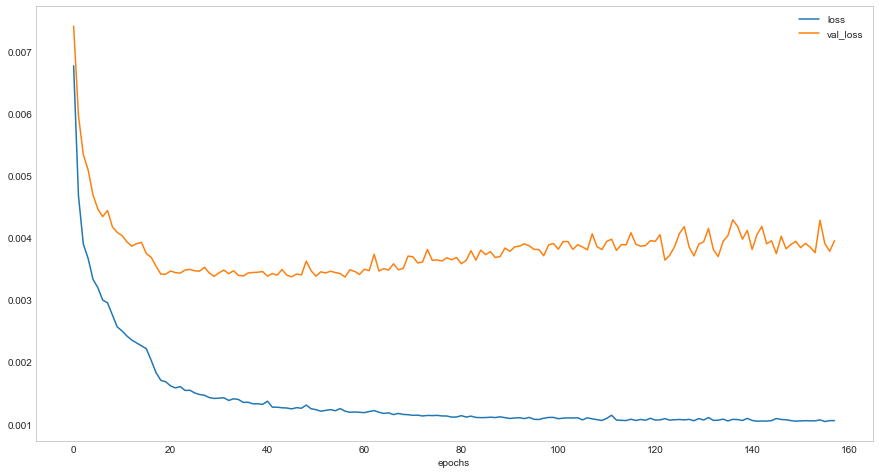

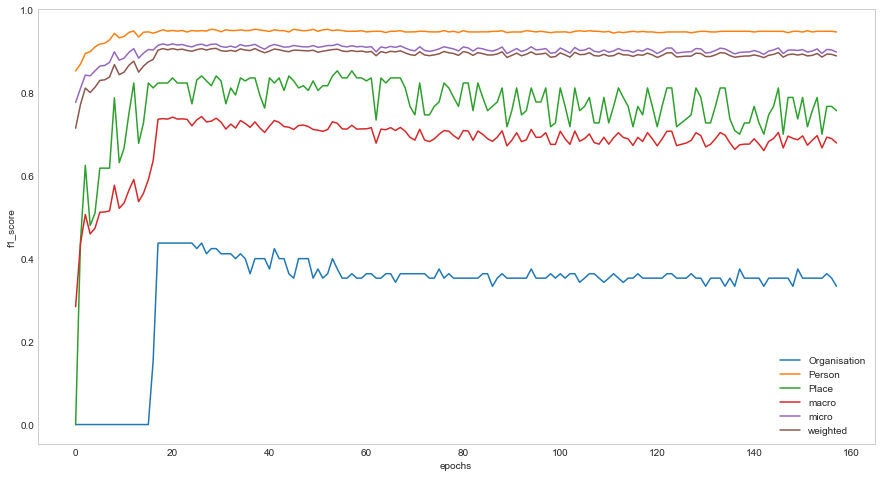

In [21]:
history_path = evaluation_folder + 'history'
getHistoryGraph(models_dict,history_path)

In [22]:
models_dict = deepcopy(model_obj)

In [23]:
mapping_folder = evaluation_folder + 'mapping/'
createFolder(mapping_folder)

for ext in models_dict['extractors_mapping']:
    comb_test = models_dict['extractors_mapping'][ext]['test']
    writer = pd.ExcelWriter(mapping_folder+ext+'.xlsx')
    for i,c in enumerate(comb_test):
        list_types_all = pickle.load(open(features_paths[i], "rb" ))['type_list']
        if ext in list_types_all:
            writer = pd.ExcelWriter(mapping_folder+ext+'.xlsx')
            list_types = list_types_all[ext]
            recs = []
            for j,l in enumerate(list_types):
                recs.append({
                    'original type':l,
                    'predicted type':c[j]
                })
            pd.DataFrame(recs).to_excel(writer,str(i))
            writer.save()

In [101]:

adel_predictions = getTypeExtractor('adel',features_paths,flatten=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,Organisation,Person,Place,macro,micro
0,alchemy,0.00,0.87,0.00,0.29,0.80
1,adel,0.00,0.75,0.00,0.25,0.68
2,opencalais,0.00,0.62,0.51,0.37,0.58
3,dandelion,0.00,0.30,0.00,0.10,0.26
4,dbspotlight,0.08,0.55,0.00,0.21,0.48
5,babelfy,0.00,0.59,0.51,0.36,0.55
6,textrazor,0.36,0.88,0.10,0.45,0.81
7,meaning_cloud,0.33,0.86,0.61,0.60,0.82
8,ensemble,0.44,0.95,0.82,0.74,0.92


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,Organisation,Person,Place,macro,micro
0,alchemy,0.00,0.82,0.00,0.27,0.82
1,adel,0.00,0.84,0.00,0.28,0.84
2,opencalais,0.00,0.85,0.68,0.51,0.83
3,dandelion,0.00,0.68,0.00,0.23,0.68
4,dbspotlight,0.50,0.85,0.00,0.45,0.85
5,babelfy,0.00,0.94,0.48,0.47,0.84
6,textrazor,0.67,0.91,0.50,0.69,0.89
7,meaning_cloud,0.83,0.89,0.76,0.83,0.88
8,ensemble,0.88,0.94,0.90,0.90,0.93


,0,Organisation,Person,Place,macro,micro
0,alchemy,0.00,0.92,0.00,0.31,0.77
1,adel,0.00,0.68,0.00,0.23,0.57
2,opencalais,0.00,0.48,0.41,0.30,0.45
3,dandelion,0.00,0.19,0.00,0.06,0.16
4,dbspotlight,0.04,0.40,0.00,0.15,0.34
5,babelfy,0.00,0.42,0.54,0.32,0.41
6,textrazor,0.25,0.85,0.05,0.39,0.74
7,meaning_cloud,0.21,0.84,0.51,0.52,0.77
8,ensemble,0.29,0.97,0.76,0.67,0.90


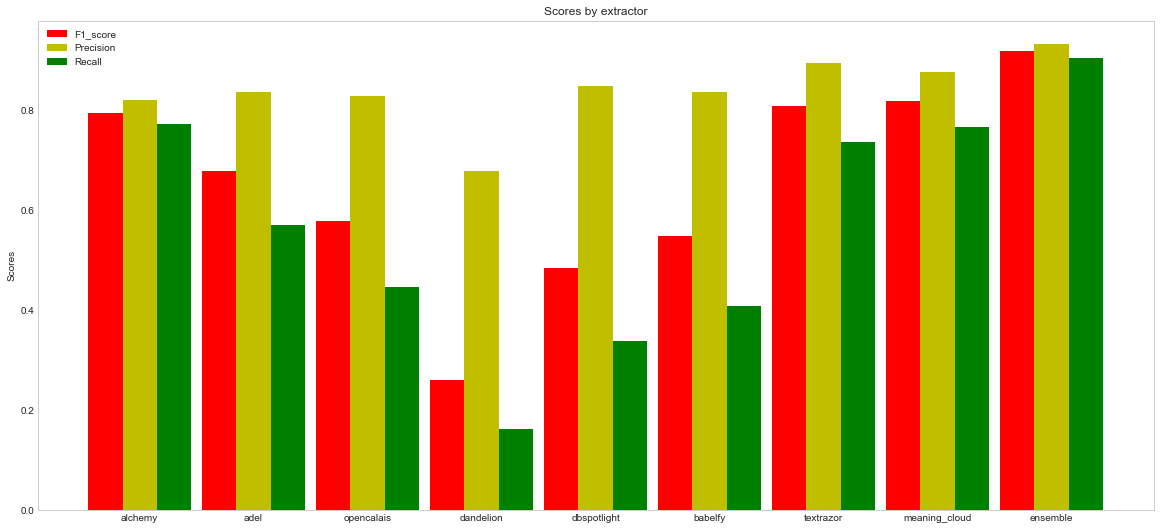

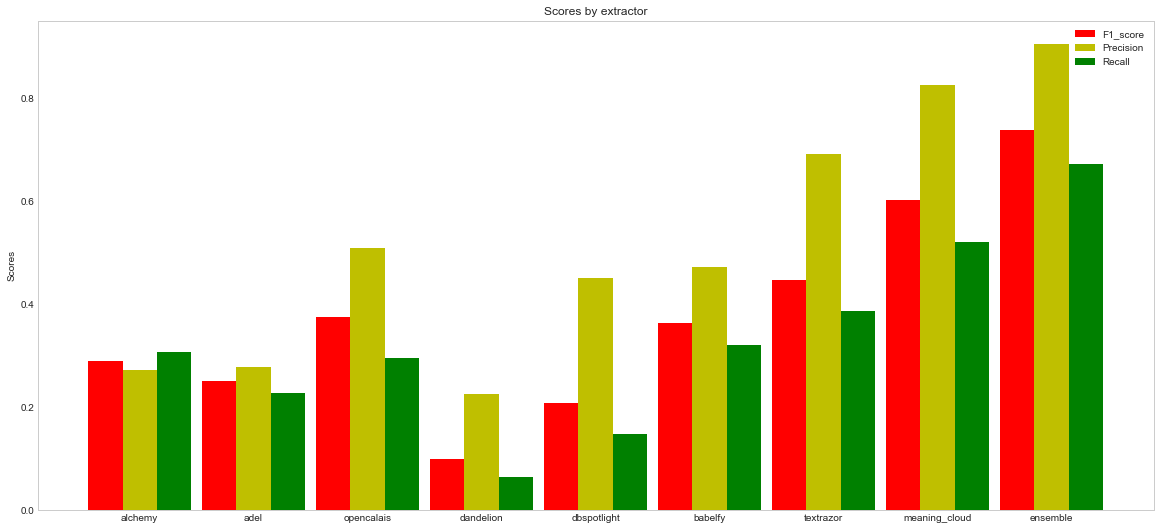

In [24]:
#BINARY SCORES
for_hist_micro = [[0,0,0] for ext in extractors_types]
for_hist_micro.append([0,0,0])
for_hist_macro = [[0,0,0] for ext in extractors_types]
for_hist_macro.append([0,0,0])
for j,key in enumerate(['f1','precision','recall']):
    recs = []
    for k,ext in enumerate(extractors_types):
        models_dict_ext = pickle.load(open( type_model_folder+ext+'/model_obj.p', "rb" ) )
        predicted_test_flatten_ext = fromPredictedToList(models_dict_ext['predicted_test'],models_dict_ext['inv_types_map'],models_dict_ext['max_fragment_len'],gt)
        obj = getScoresToken(gt_flatten,predicted_test_flatten_ext,scores[key])
        obj['0'] = ext 
        recs.append(obj)
        for_hist_micro[k][j] = obj['micro']
        for_hist_macro[k][j] = obj['macro']

    obj = getScoresToken(gt_flatten,predicted_test_flatten,scores[key])
    obj['0'] = 'ensemble'
    for_hist_micro[-1][j] = obj['micro']
    for_hist_macro[-1][j] = obj['macro']
    recs.append(obj)
    writer = pd.ExcelWriter(evaluation_folder+key+'.xlsx')
    df = pd.DataFrame(recs)
    df = df.round(2)
    display(df)
    df.to_excel(writer)
    writer.save()
    
generateHistogram(for_hist_micro,evaluation_folder+'micro_hist.png',extractors_types)
generateHistogram(for_hist_macro,evaluation_folder+'macro_hist.png',extractors_types)

In [69]:
import re

def formBRATandSave(entities,text,output_path):
    BASIC_BRAT_ANN = 'TINDEX\tTYPE START END\tSURFACE'
    brat_lines = list()
    for i,e in enumerate(entities):
        index_ = str(i+1)
        type_ = e['type']
        start_ = str(e['start'])
        end_ = str(e['end']+1)
        text_ = text[e['start']:e['end']+1]
        b_l = BASIC_BRAT_ANN.replace('INDEX',index_).replace('TYPE',type_).replace('START',start_).replace('END',end_).replace('SURFACE',text_)
        brat_lines.append(b_l)
    with open(output_path,'w+') as f_out:
        f_out.write('\n'.join(brat_lines))
        
        
def estimateContinueInfo(predicted):
    offsets = list()
    for j,type_ in enumerate(predicted):
        if type_ == '0':
            offsets.append(0)
        else:
            if j != len(predicted) - 1 and predicted[j+1] == type_:
                offsets.append(1)
            else:
                offsets.append(0)
    return offsets

def addContinueInfo(evaluation_obj):
    for dataset in evaluation_obj:
        for ext in evaluation_obj[dataset]:
            predicted_per_file = evaluation_obj[dataset][ext]['predicted_per_file']
            evaluation_obj[dataset][ext]['offsets'] = [estimateContinueInfo(pred) for pred in predicted_per_file]
    return evaluation_obj



def getOffsetListGT(groundtruth_paths):
    offset_df_per_file = list()
    for g in groundtruth_paths:
        recs_gt = pd.read_csv(g).to_dict(orient='records')
        offsets = [r['continue'] for r in recs_gt]
        offset_df_per_file.append(offsets)
    return offset_df_per_file

def generateBRATFiles(output_folder,segments_names,texts_paths,offsets_per_file,types_per_file,texts_tokens_per_file):
    for i,t_list in enumerate(types_per_file):
        entities = getNamedEntities(t_list,offsets_per_file[i],texts_tokens_per_file[i])
        text = open(texts_paths[i]).read()
        output_path = output_folder + segments_names[i] + '.ann'
        formBRATandSave(entities,text,output_path)
        
def getTextTokensList(texts_paths):
    texts_splitted_per_file = list()
    for path in texts_paths:
        with open(path) as f:
            texts_splitted_per_file.append(splitInTokens(f.read()))
    return texts_splitted_per_file
import string

def isGoodChar(c):
    return c.isalpha() or c.isdigit()

splitting_chars = list()
for ch in string.printable:
    if not isGoodChar(ch):
        splitting_chars.append(ch)
def splitInTokens(string):
    s=string.lower()
    final_tuples = ([(m.group(0), m.start(),m.start()+len(m.group(0))-1)
                    for m in re.finditer(re.compile('[^'+''.join(splitting_chars)+']+')
                                         , s)]
                    +
                    [(m.group(0), m.start(),m.start()+len(m.group(0))-1)
                    for m in re.finditer(re.compile('['+''.join(splitting_chars[:-6])+']')
                                         , s)]
    )
    final_tuples.sort(key=lambda x:x[1])
    return final_tuples

def getNamedEntities(type_tokens,offsets,texts_tokens):
    entities = list()
    start_end = list()
    for i,t in enumerate(type_tokens):
        if t != '0':
            start = texts_tokens[i][1]
            end = texts_tokens[i][2]
            if bool(start_end):
                start_end[1] = end
            else:
                start_end = [start,end]
            if bool(offsets[i]):
                pass
            else:
                entities.append({
                    'type':t,
                    'start':start_end[0],
                    'end':start_end[1]
                })
                start_end = []
        else:
            start_end = []
        
    return entities

In [26]:
segments = [t.split('/')[-1].split('.')[0] for t in groundtruth_paths]
gt_offset = getOffsetListGT(groundtruth_paths)
brat_truth_folder  = training_folder + 'test/brat_ground_truth/'
texts_splitted_per_file = getTextTokensList(texts_paths)
createFolder(brat_truth_folder)
generateBRATFiles(brat_truth_folder,
                  segments,texts_paths,
                  gt_offset,gt,texts_splitted_per_file)

In [28]:
predicted_test = fromPredictedToList(models_dict['predicted_test'],models_dict['inv_types_map'],models_dict['max_fragment_len'],gt,flat=False)

brat_folder = evaluation_folder + 'brat/combination/'
createFolder(brat_folder)
generateBRATFiles(brat_folder,
                  segments,texts_paths,
                  [estimateContinueInfo(pred) for pred in predicted_test],predicted_test,texts_splitted_per_file)
for k,ext in enumerate(extractors_types):
    brat_folder = evaluation_folder + 'brat/'+ext+'/'
    createFolder(brat_folder)
    models_dict_ext = pickle.load(open( type_model_folder+ext+'/model_obj.p', "rb" ) )
    predicted_test_ext = fromPredictedToList(models_dict_ext['predicted_test'],models_dict_ext['inv_types_map'],models_dict_ext['max_fragment_len'],gt,flat=False)
    generateBRATFiles(brat_folder,
                      segments,texts_paths,
                      [estimateContinueInfo(pred) for pred in predicted_test_ext],predicted_test_ext,texts_splitted_per_file)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


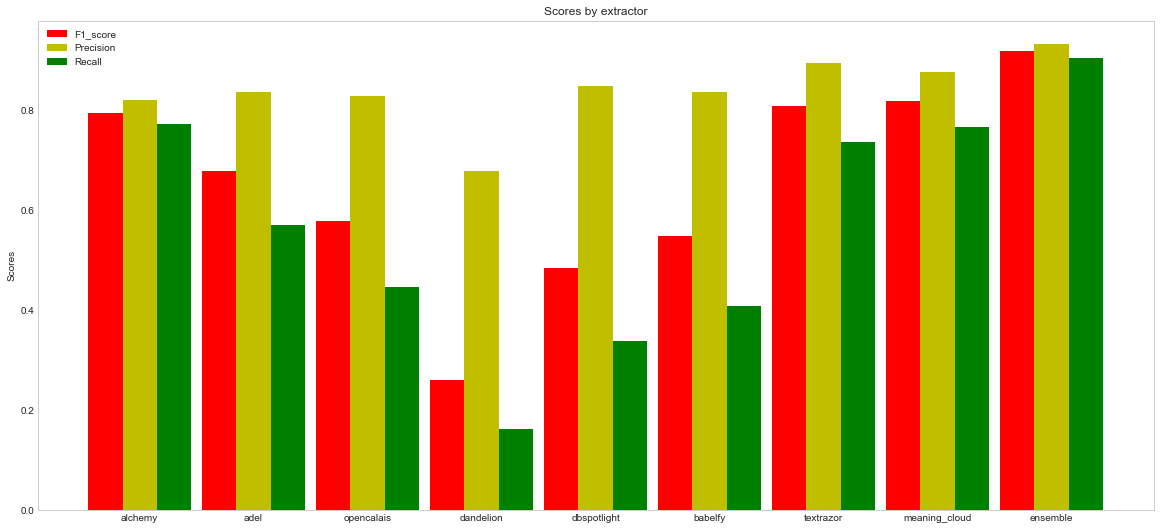

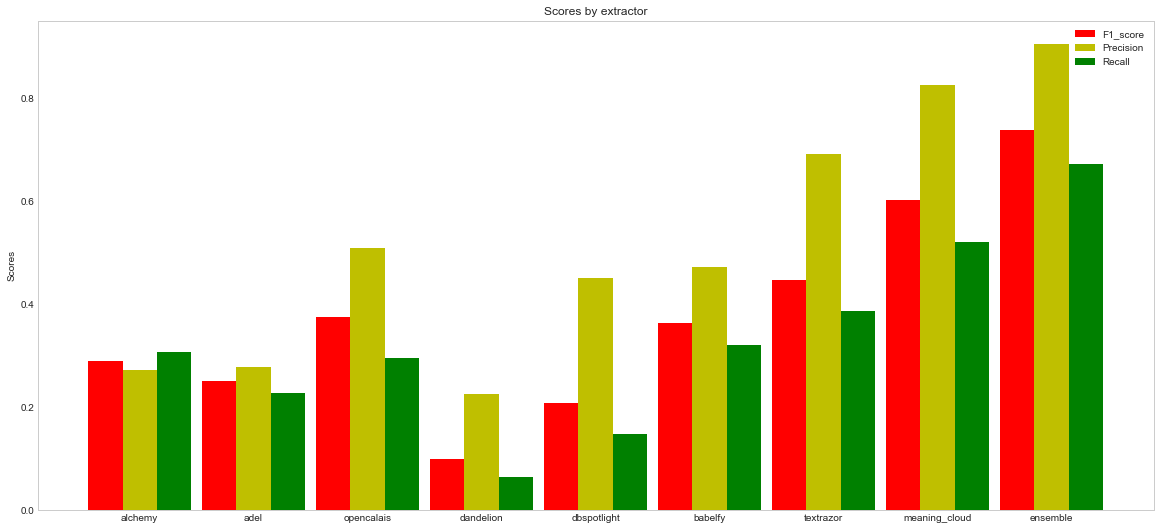

In [29]:
for_hist_micro = [[0,0,0] for ext in extractors_types]
for_hist_micro.append([0,0,0])
for_hist_macro = [[0,0,0] for ext in extractors_types]
for_hist_macro.append([0,0,0])
for j,key in enumerate(['f1','precision','recall']):
    recs = []
    for k,ext in enumerate(extractors_types):
        models_dict_ext = pickle.load(open( type_model_folder+ext+'/model_obj.p', "rb" ) )
        predicted_test_flatten_ext = fromPredictedToList(models_dict_ext['predicted_test'],models_dict_ext['inv_types_map'],models_dict_ext['max_fragment_len'],gt)
        obj = getScoresToken(gt_flatten,predicted_test_flatten_ext,scores[key])
        obj['0'] = ext 
        recs.append(obj)
        for_hist_micro[k][j] = obj['micro']
        for_hist_macro[k][j] = obj['macro']

    obj = getScoresToken(gt_flatten,predicted_test_flatten,scores[key])
    for_hist_micro[-1][j] = obj['micro']
    for_hist_macro[-1][j] = obj['macro']
    recs.append(obj)
    writer = pd.ExcelWriter(evaluation_folder+key+'.xlsx')
    pd.DataFrame(recs).to_excel(writer)
    writer.save()
    
generateHistogram(for_hist_micro,evaluation_folder+'micro_hist.png',extractors_types)
generateHistogram(for_hist_macro,evaluation_folder+'macro_hist.png',extractors_types)

In [58]:
recs = []
for f in ['type', 'score', 'uris','fasttext']:
    models_dict_ext = pickle.load(open( m_fold+'best_'+f+'/model_obj_'+f+'.p', "rb" ) )

    predicted_test_flatten_ext = fromPredictedToList(models_dict_ext['predicted_test'],models_dict_ext['inv_types_map'],models_dict_ext['max_fragment_len'],gt)
    obj = getScoresToken(gt_flatten,predicted_test_flatten_ext,scores[key])
    obj['0'] = f
    recs.append(obj)
    print(obj)
    
    
df = pd.DataFrame(recs)

writer = pd.ExcelWriter(m_fold+'best_'+f+'/features_importance_1.xlsx')
df.to_excel(writer)
writer.save()
    

{'Place': 0.4375, 'Person': 0.86896551724137927, 'Role': 0.57999999999999996, 'Organization': 0.60687022900763354, 'micro': 0.64973730297723298, 'macro': 0.62333393656225322, '0': 'type'}
{'Place': 0.890625, 'Person': 0.9517241379310345, 'Role': 0.88, 'Organization': 0.86641221374045807, 'micro': 0.89316987740805609, 'macro': 0.89719033791787317, '0': 'score'}
{'Place': 0.828125, 'Person': 0.9517241379310345, 'Role': 0.88, 'Organization': 0.90458015267175573, 'micro': 0.90367775831873909, 'macro': 0.89110732265069759, '0': 'uris'}
{'Place': 0.90625, 'Person': 0.90344827586206899, 'Role': 0.91000000000000003, 'Organization': 0.86641221374045807, 'micro': 0.88791593695271454, 'macro': 0.89652762240063177, '0': 'fasttext'}


In [59]:
recs = []
for f in ['type', 'score', 'uris','fasttext']:
    models_dict_ext = pickle.load(open( m_fold+'best_'+f+'_b/model_obj_'+f+'.p', "rb" ) )

    predicted_test_flatten_ext = fromPredictedToList(models_dict_ext['predicted_test'],models_dict_ext['inv_types_map'],models_dict_ext['max_fragment_len'],gt)
    obj = getScoresToken(gt_flatten,predicted_test_flatten_ext,scores[key])
    obj['0'] = f
    recs.append(obj)
    print(obj)
    
df = pd.DataFrame(recs)

writer = pd.ExcelWriter(m_fold+'best_'+f+'/features_importance_2.xlsx')
df.to_excel(writer)
writer.save()

{'Place': 0.921875, 'Person': 0.87586206896551722, 'Role': 0.91000000000000003, 'Organization': 0.86259541984732824, 'micro': 0.88091068301225917, 'macro': 0.89258312220321134, '0': 'type'}
{'Place': 0.0, 'Person': 0.30344827586206896, 'Role': 0.0, 'Organization': 0.33587786259541985, 'micro': 0.23117338003502627, 'macro': 0.15983153461437222, '0': 'score'}
{'Place': 0.0, 'Person': 0.55862068965517242, 'Role': 0.0, 'Organization': 0.56870229007633588, 'micro': 0.40280210157618213, 'macro': 0.28183074493287708, '0': 'uris'}
{'Place': 0.375, 'Person': 0.64827586206896548, 'Role': 0.57999999999999996, 'Organization': 0.38549618320610685, 'micro': 0.48511383537653241, 'macro': 0.49719301131876809, '0': 'fasttext'}


In [61]:
f

'fasttext'